# Sun Shadows Computation

### Possible data sources

- Sun data can be downloaded from http://aa.usno.navy.mil/data/docs/AltAz.php
- Webcam: Nav Canada Location: Kelowna Airport (CYLW) N49 57 22 W119 22 40 Airport ELEV: 1409' MSL http://www.metcam.navcanada.ca/dawc_images/wxcam/CYLW/CYLW_N-full-e.jpeg
- Webcam Glacier National Park (Montana) (Apgar Village): http://www.nps.gov/webcams-glac/apvccam.jpg
- Boulevard, California, USA: Clover Flat Elementary School: http://wwc.instacam.com/instacamimg/BLVRD/BLVRD_l.jpg (source: http://www.webcamgalore.com/EN/webcam/USA/Boulevard-California/25012.html)
- Webcam Descanso, California, USA: Cuyamaca Peak (there are other nice webcam) http://www.creekbed.org/cuyacam_000.jpg (source: http://creekbed.org/bandh/webcams.htm)
- Arizona Phoenix: http://www.phoenixvis.net/CreateMain.aspx?t=main&p=/images/photos-main/SOMT1.jpg (source: http://www.phoenixvis.net/site.aspx?site=somt1)
- Tenerife Observatory Canary Islands, Spain: http://www.telescope.org/v4webcams-i.php?cam=teide&ts=1446042877 (source: http://www.telescope.org/v4webcams.php)

### Installation
- Download JSAnimator from https://github.com/jakevdp/JSAnimation/archive/master.zip
- Extract the compressed files.
- Run the following command for a local install:

```
$ python setup.py install --user
```

- Download PySolar from http://pysolar.org/
- Extract the compressed files.
- Run the following command for a local install:

```
$ python setup.py install --user
```

### TODO
- Check why the data seems 15 minutes off
- why 1h05 off from U.S Naval Dep.
- effective sun set should handle East and West separatly and it's related on obstacle at the horizon

In [1]:
%matplotlib inline

from IPython.display import Latex

# math
import numpy as np
from numpy.linalg import norm

# ploting
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.dates import DateFormatter

# time 
from datetime import datetime
from dateutil import tz
from dateutil import rrule

# for animation
from JSAnimation import IPython_display
from matplotlib import animation

# for sun information
import Pysolar.solar as slr

# for data structure
import pandas as pd

In [229]:
# useful constants
format_HM = DateFormatter('%H:%M')

# different dawns
horizon_shadows = np.radians(10)
effective_horizon = np.radians(10)
sensor_limit = np.radians(-12) 
dawn_civil = np.radians(-6)         # street lights are required to continue normal activities
dawn_nautical = np.radians(-12)     # sailors can take reliable star sightings of well-known stars
dawn_astronomical = np.radians(-18) # dark enough to watch the stars

# coordinates (latitude, longitude) in deg
coord_utias = [43.781914, -79.465478]
coord_csa = [45.517838, -73.392678]

# experiment dates
test_start_time = '2015-10-20 04:00:00'
test_end_time = '2015-10-20 23:00:00'

csa_start_time = '2014-05-12 04:00:00'
csa_end_time = '2014-05-12 23:00:00'

utias_start_time = '2014-04-24 04:00:00'
utias_end_time = '2014-04-24 23:00:00'

winter_start_time = '2014-12-12 04:00:00' # confirm that
winter_end_time = '2014-12-12 23:00:00'   # confirm that


In [207]:
def get_utc(when):
    ''' convert local time (Toronto) to UTC time. '''

    date_local = datetime.strptime(when, '%Y-%m-%d %H:%M:%S')
    date_local = date_local.replace(tzinfo=tz.gettz('America/Toronto'))
    date_utc = date_local.astimezone(tz.tzutc())
    
    return date_utc

In [4]:
def extract_sun_data(start_time, end_time, coord):
    ''' Generate sun altitude, azimuth and radiation for a range of time 

    Arguments:
    start_time -- string representing time in Toronto (ex.: '2014-05-12 05:00:00')
    end_time   -- string representing time in Toronto (ex.: '2014-05-12 23:00:00')
    '''
    start_utc = get_utc(start_time)
    end_utc = get_utc(end_time)

    table = pd.DataFrame(columns=('date', 'sun_altitude', 'sun_azimuth'))
    for date_utc in rrule.rrule(rrule.MINUTELY, interval=5, dtstart=start_utc, until=end_utc):

        sun_altitude = slr.GetAltitude(coord[0], coord[1], date_utc)
        sun_azimuth = slr.GetAzimuth(coord_utias[0], coord_utias[1], date_utc)
        # Bug in function:
        #sun_radiation = slr.radiation.GetRadiationDirect(date_utc, sun_altitude)
        date_local = date_utc.astimezone(tz.gettz('America/Toronto'))
        date_local = date_local.replace(tzinfo=None)
        table.loc[len(table)] = [date_local, np.radians(sun_altitude), np.radians(sun_azimuth)]
        #table.loc[len(table)] = [date_local, (sun_altitude), (sun_azimuth)]

    table.index = table.date
    table.pop('date')
    
    return table


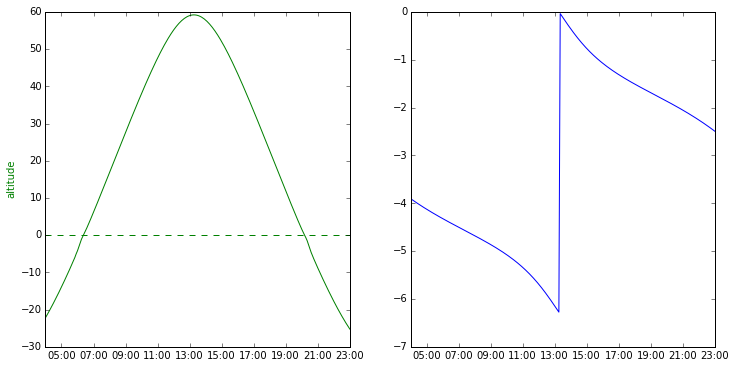

In [5]:

# extract sun data with dates of CSA's experiment
#table = extract_sun_data(csa_start_time, csa_end_time, coord_utias)
table = extract_sun_data(utias_start_time, utias_end_time, coord_utias)
#table = extract_sun_data(winter_start_time, winter_end_time, coord_utias)
#table = extract_sun_data(test_start_time, test_end_time, coord_utias)

fig =plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(table.index, np.degrees(table.sun_altitude), 'g')
ax1.axhline(0, color='g', ls='--')
ax1.set_ylabel('altitude', color='g')
ax1.xaxis.set_major_formatter(format_HM)

ax3 = fig.add_subplot(122)
ax3.plot(table.index, table.sun_azimuth)
ax3.xaxis.set_major_formatter(format_HM)

## Validate the output of PySolar with the U.S Naval Department

In [ ]:
# skip 20 lines
file_path = './sun_data/SunPathTorontoSummer.txt'

table_pysolar = extract_sun_data(utias_start_time, utias_end_time, coord_utias)

table_us_naval = pd.read_csv(file_path, sep='     ', 
                             skiprows=20, header=None, engine='python', 
                             names= ('date', 'sun_altitude', 'sun_azimuth'))
# convert to radians
table_us_naval.sun_altitude = np.radians(table_us_naval.sun_altitude)
table_us_naval.sun_azimuth = np.radians(table_us_naval.sun_azimuth)
dates = table_us_naval.index
#table_us_naval.index = table_us_naval.index.map(lambda dt: dt.replace(day=1))
#table_us_naval.index = table_us_naval.index.apply(lambda dt: dt.replace(day=1))

table_us_naval.head(3)
start_utc = get_utc(utias_start_time)
start_utc.month

table_us_naval.date = table_us_naval.date.apply(lambda dt: "%i-%i-%i %s" %(start_utc.year, start_utc.month, start_utc.day, dt))
table_us_naval.date = pd.to_datetime(table_us_naval.date)
table_us_naval.index = table_us_naval.date
table_us_naval.pop('date')

Offset between data sets: 0 days 01:05:00


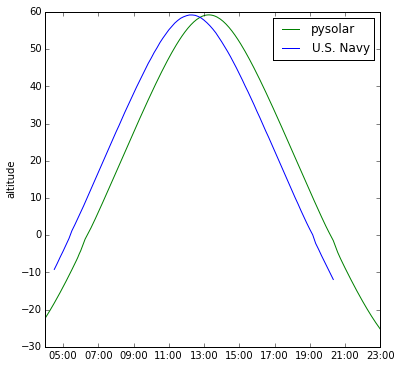

In [73]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(table_pysolar.index, np.degrees(table_pysolar.sun_altitude), 'g', label='pysolar')
ax.plot(table_us_naval.index, np.degrees(table_us_naval.sun_altitude), 'b', label='U.S. Navy')
ax.set_ylabel('altitude')
plt.legend()
ax.xaxis.set_major_formatter(format_HM)

print 'Offset between data sets: %s' % str(table_pysolar.sun_altitude.argmax() - table_us_naval.sun_altitude.argmax())


In [232]:
def compute_shadow(object_height, altitude, azimuth):
    
    if(altitude > 0):
        shadow_length = object_height/np.tan(altitude)
    else:
        shadow_length = 100000 # was infinit
        
    x = shadow_length * np.cos(azimuth)
    y = shadow_length * np.sin(azimuth)
    
    x_base = object_radius * np.sin(-azimuth)
    y_base = object_radius * np.cos(-azimuth)
    
    return np.array([[x,y],[-x_base, -y_base],[x_base, y_base]])

In [38]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y



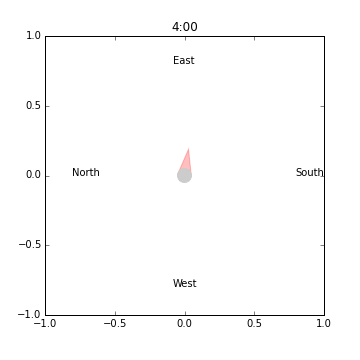
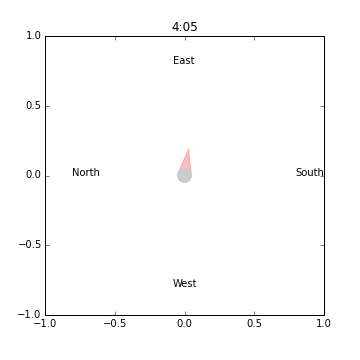
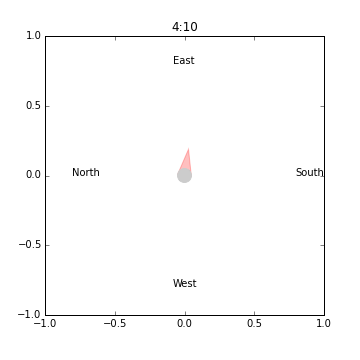
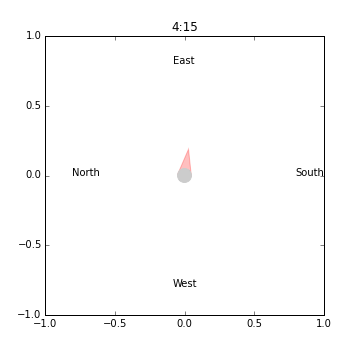
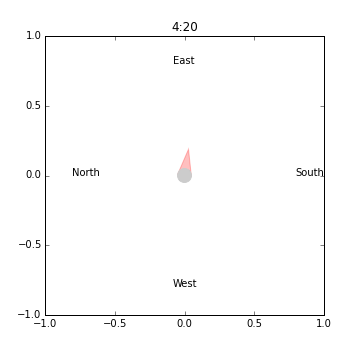
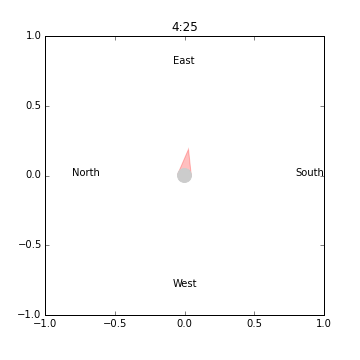
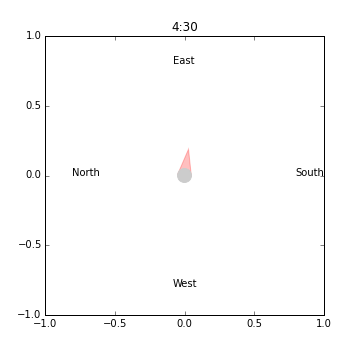
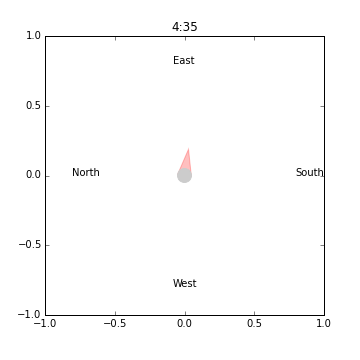
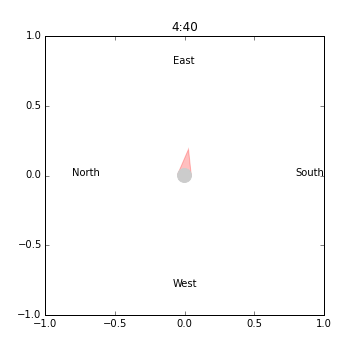
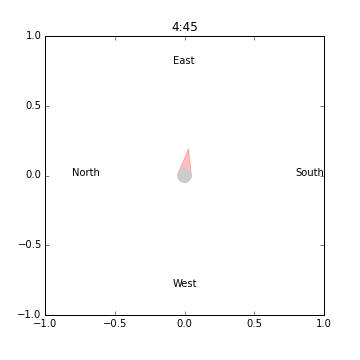
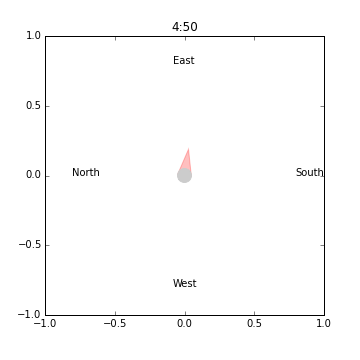
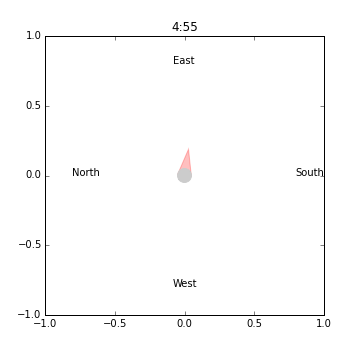
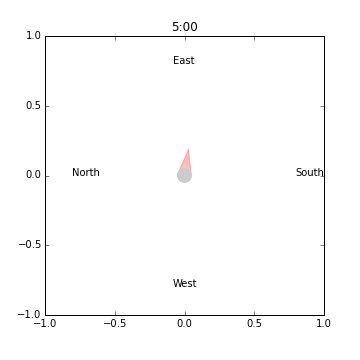
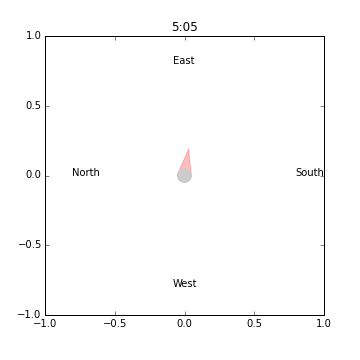
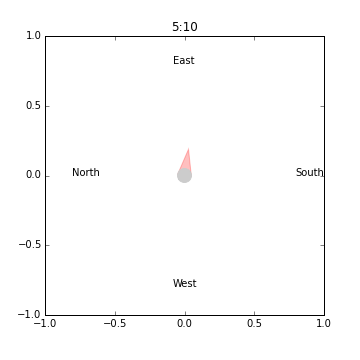
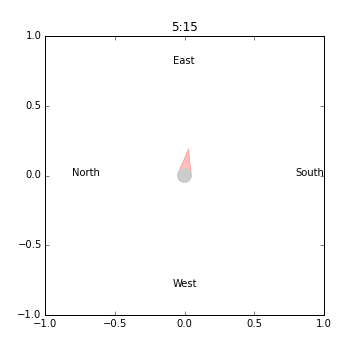
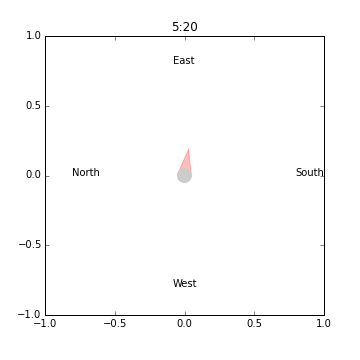
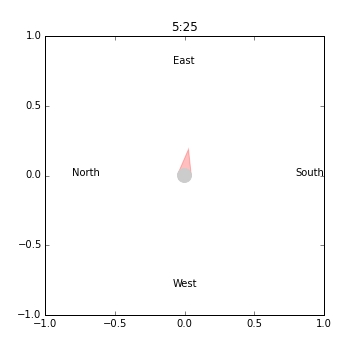
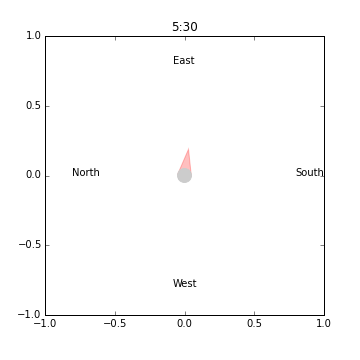
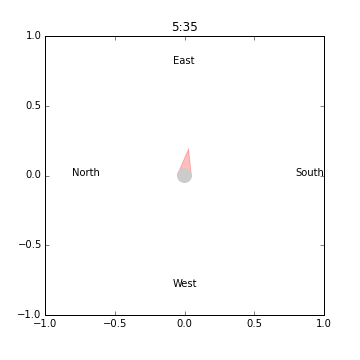
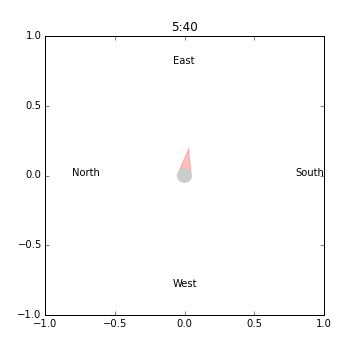
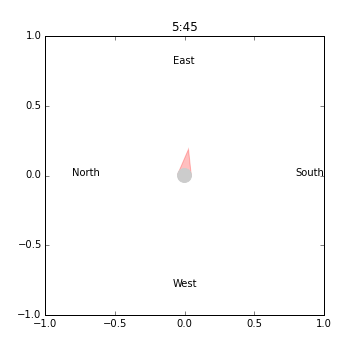
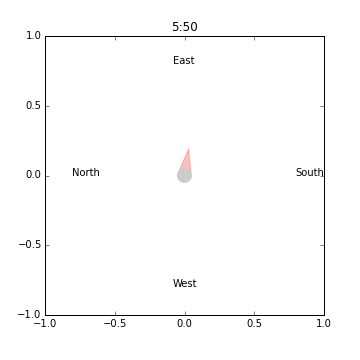
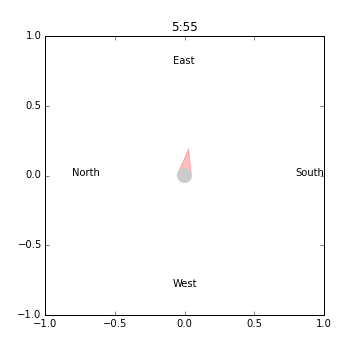
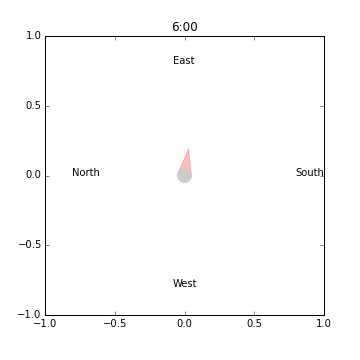
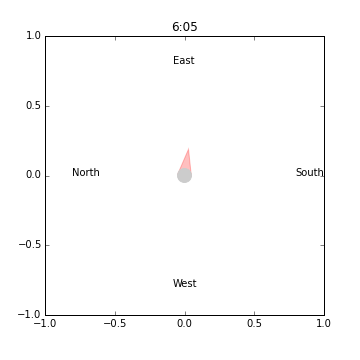
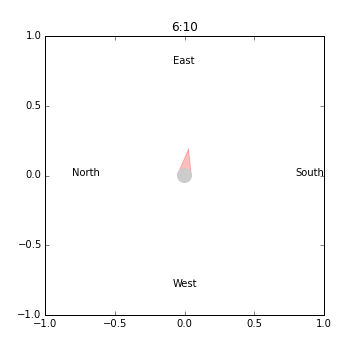
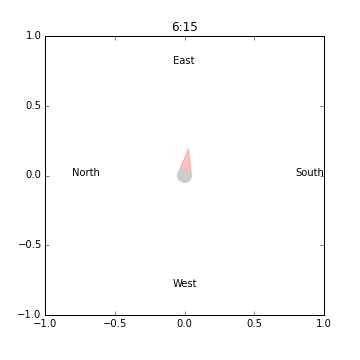
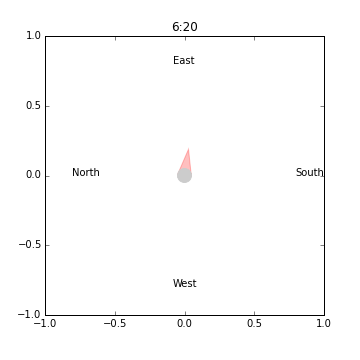
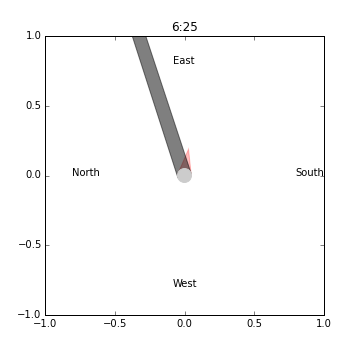
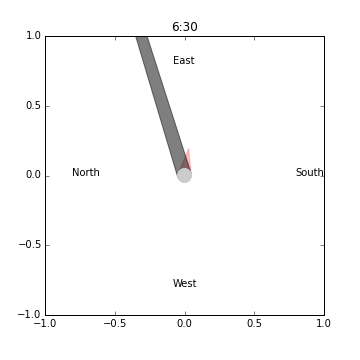
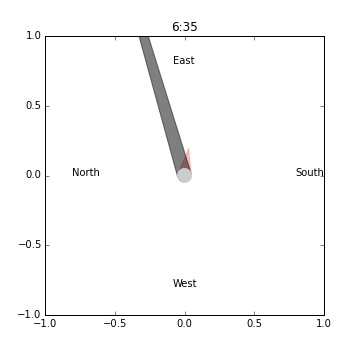
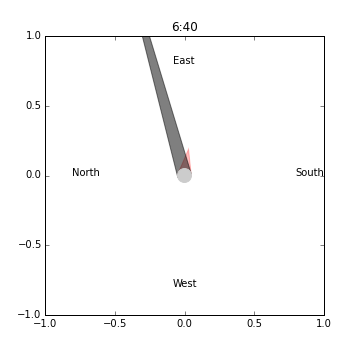
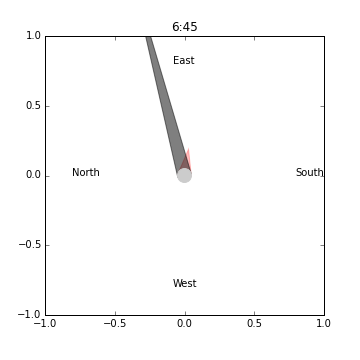
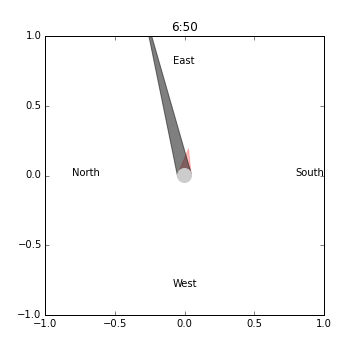
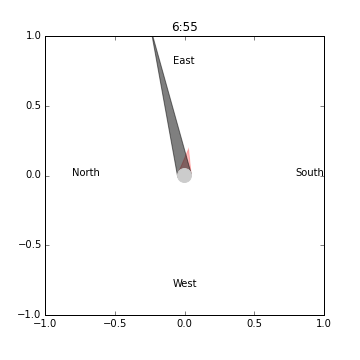
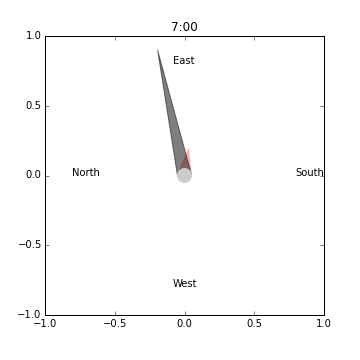
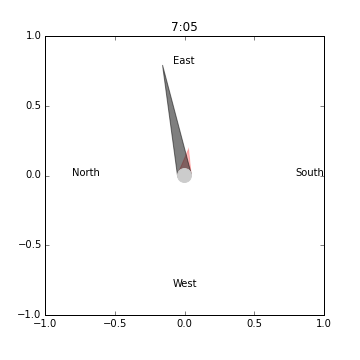
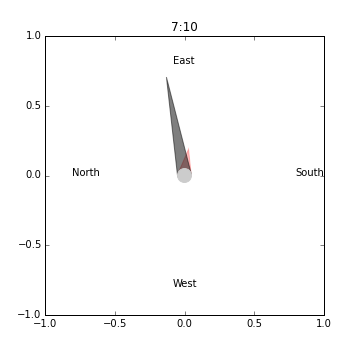
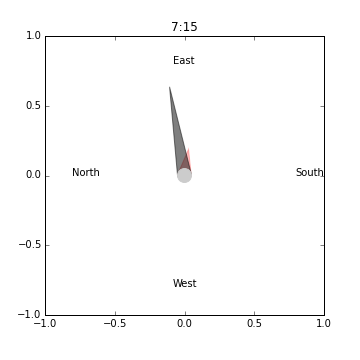
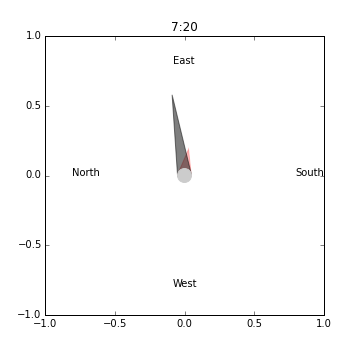
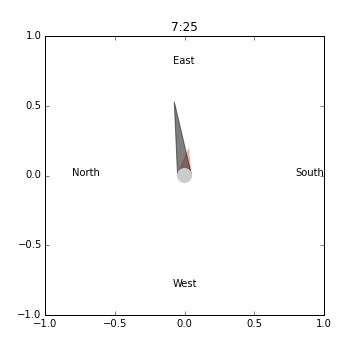
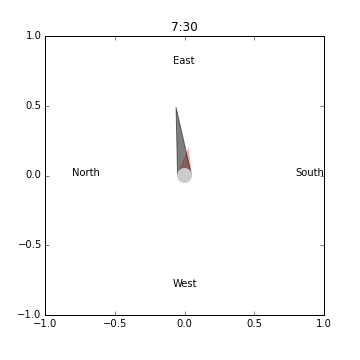
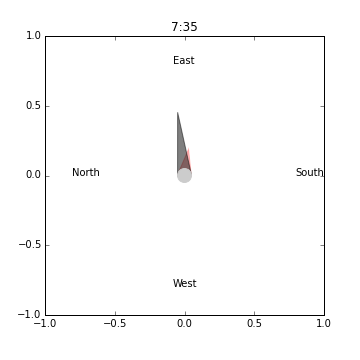
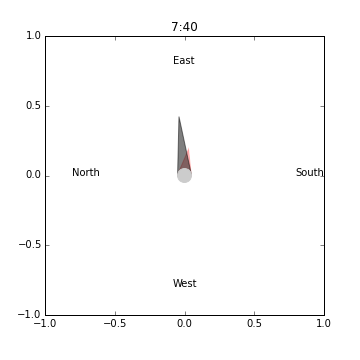
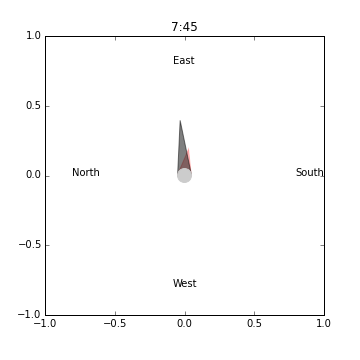
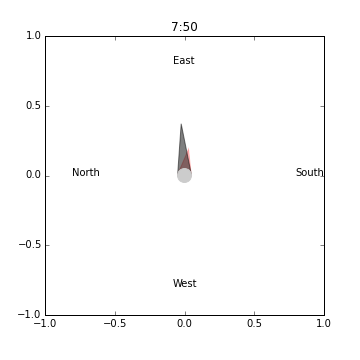
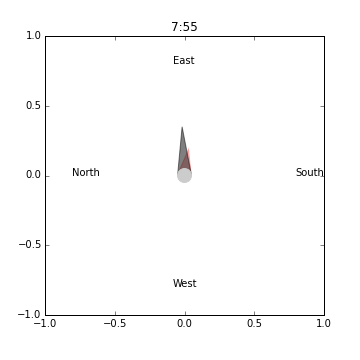
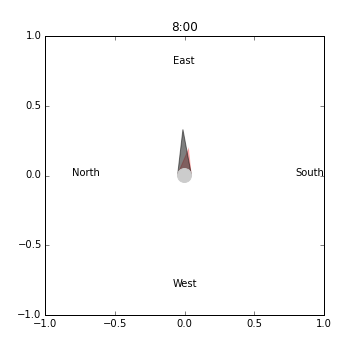
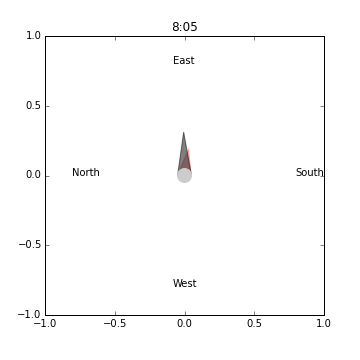
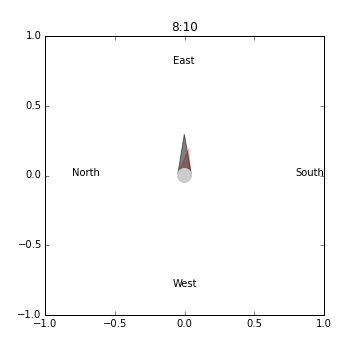
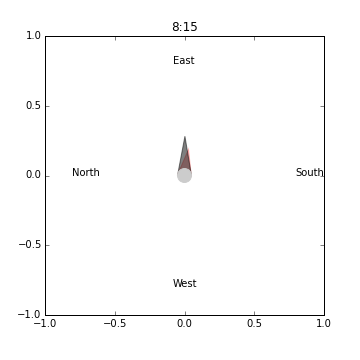
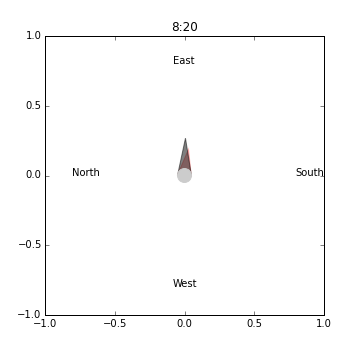
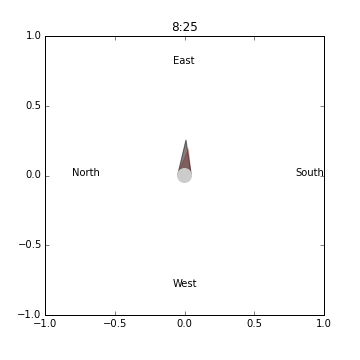
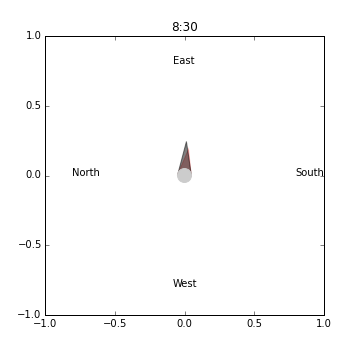
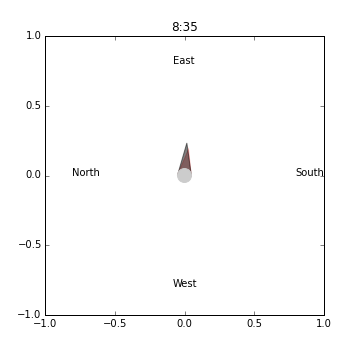
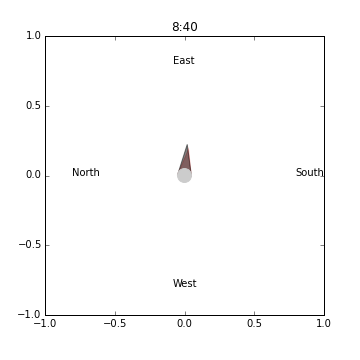
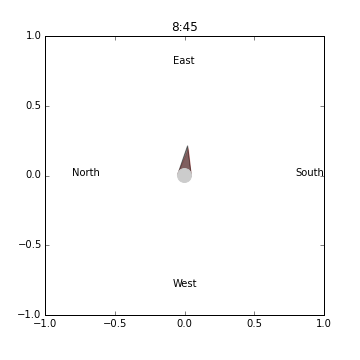
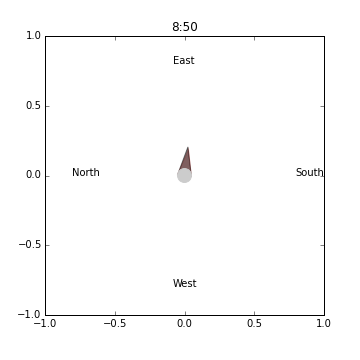
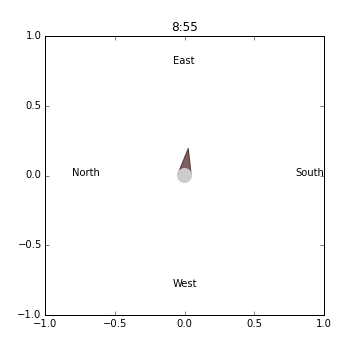
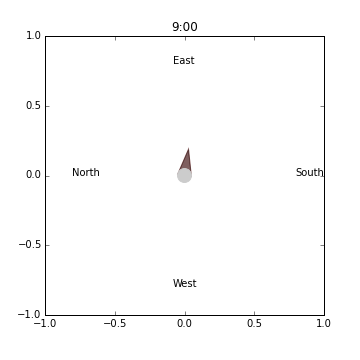
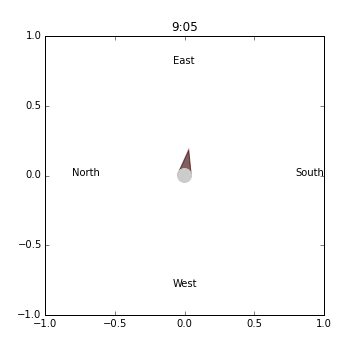
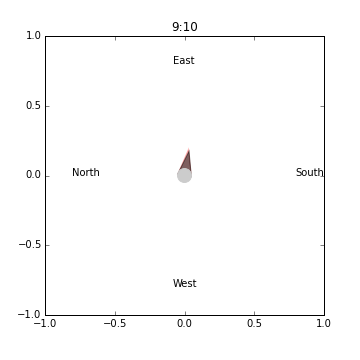
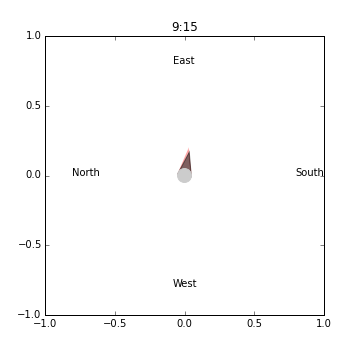
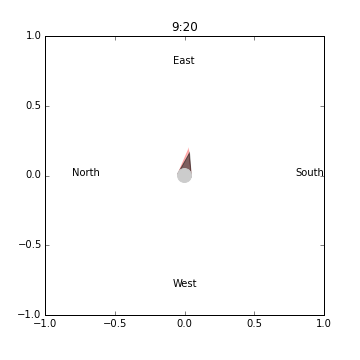
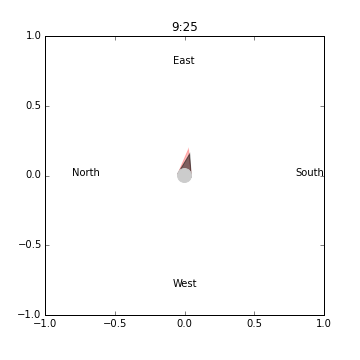
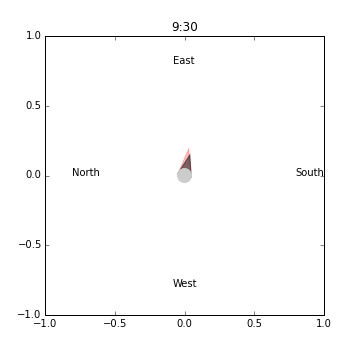
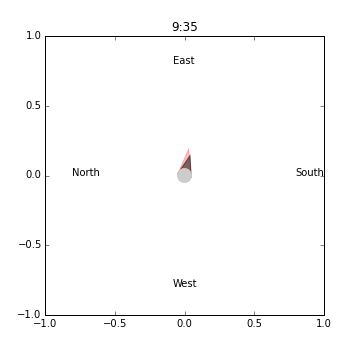
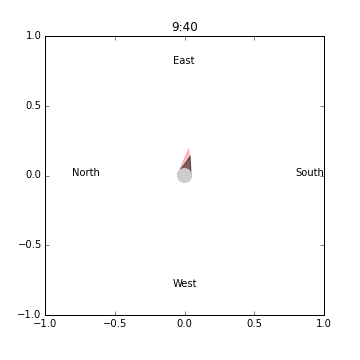
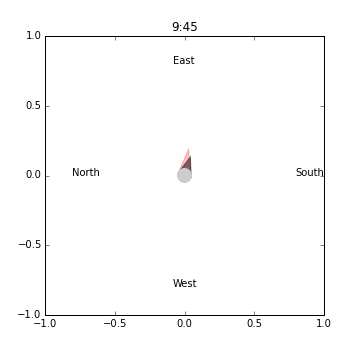
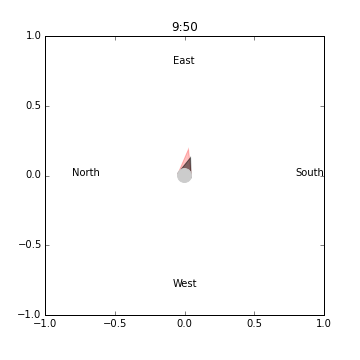
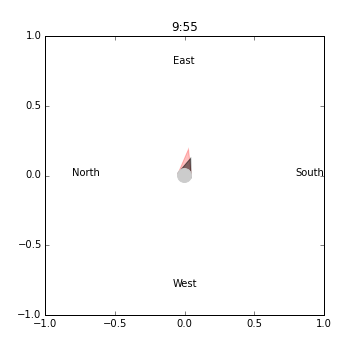
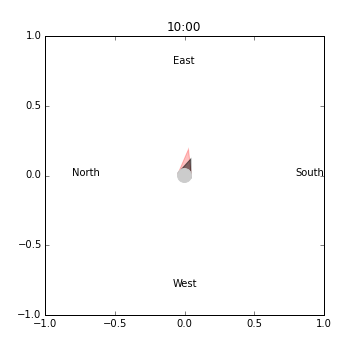
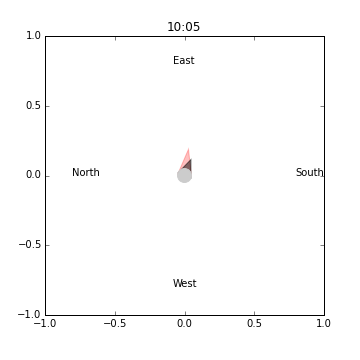
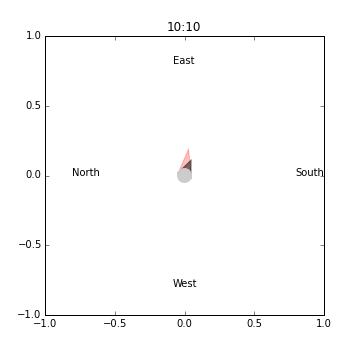
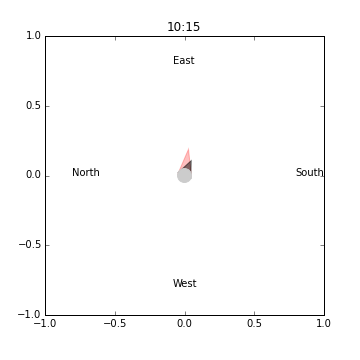
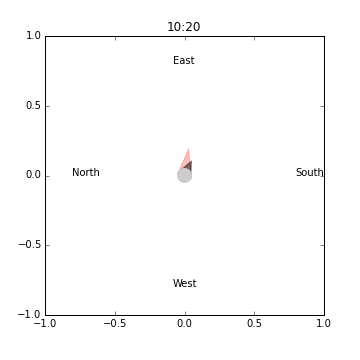
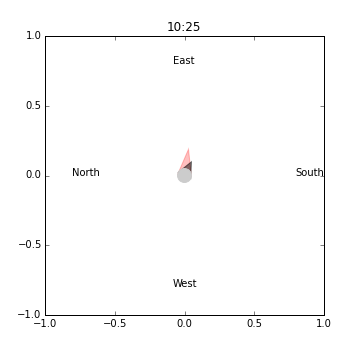
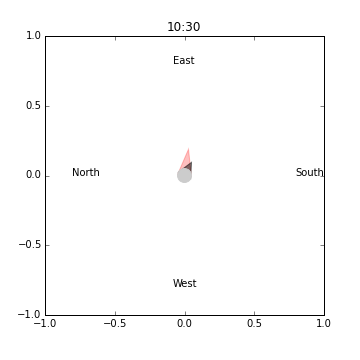
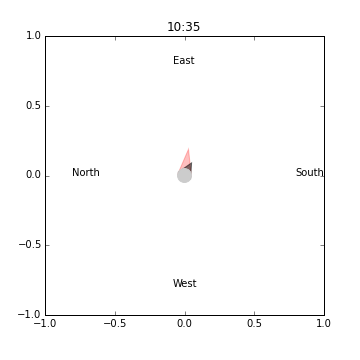
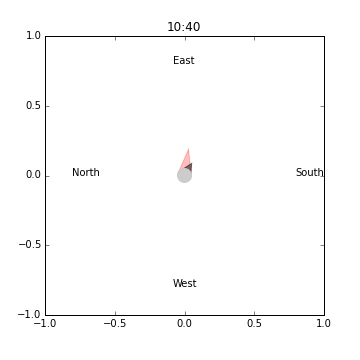
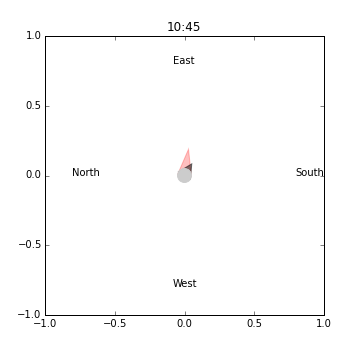
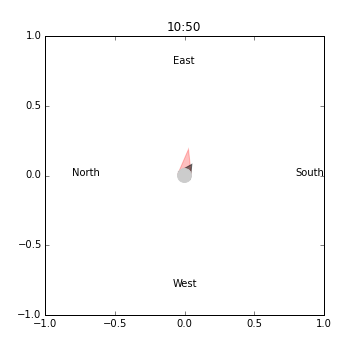
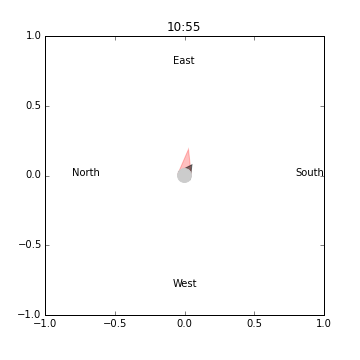
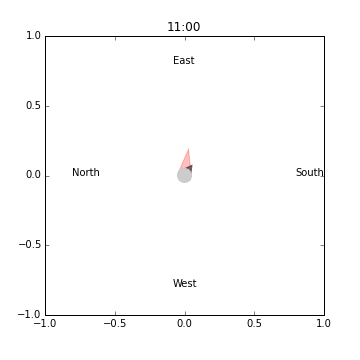
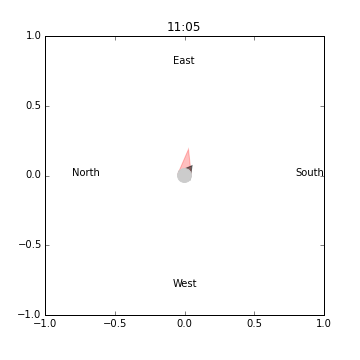
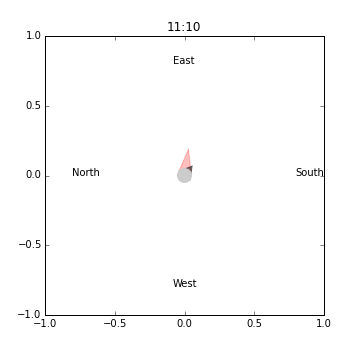
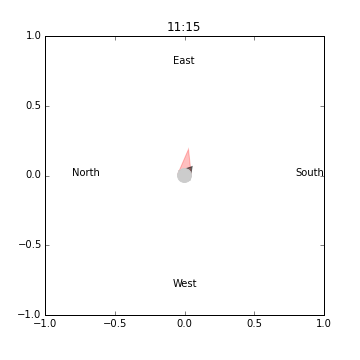
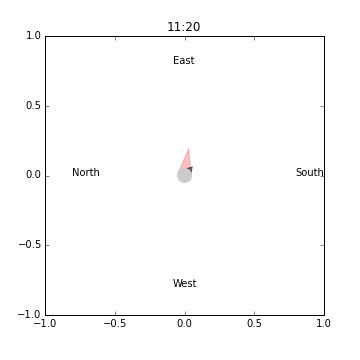
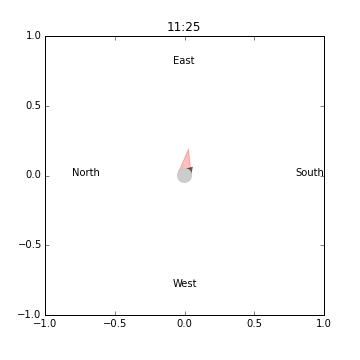
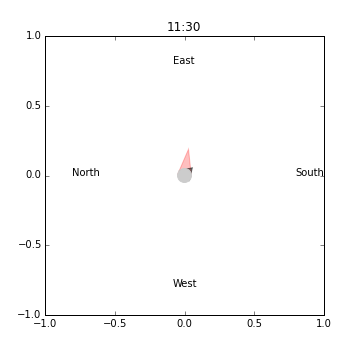
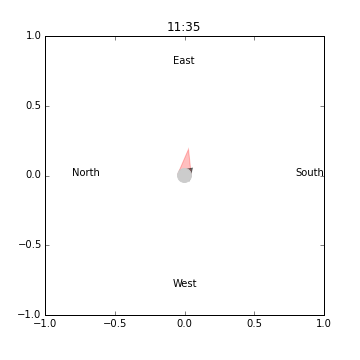
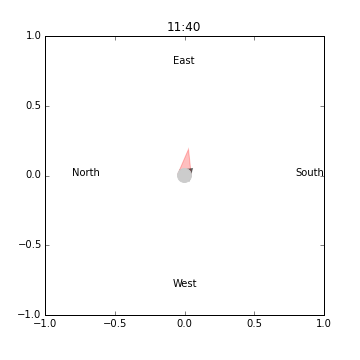
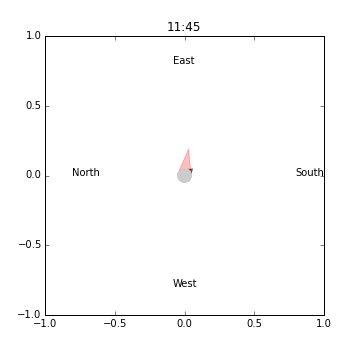
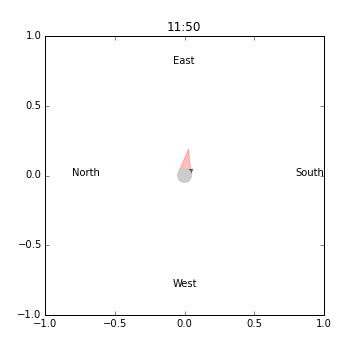
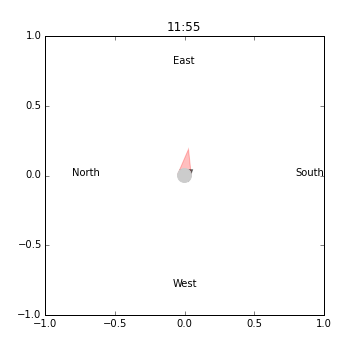
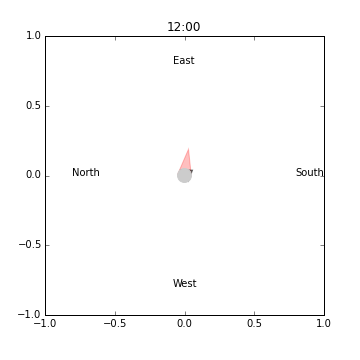
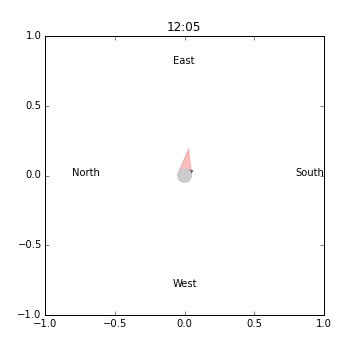
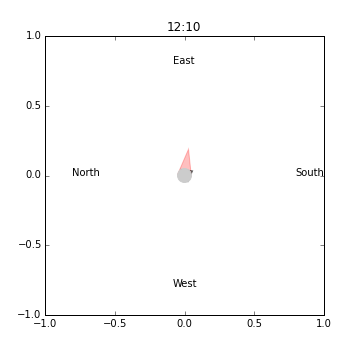
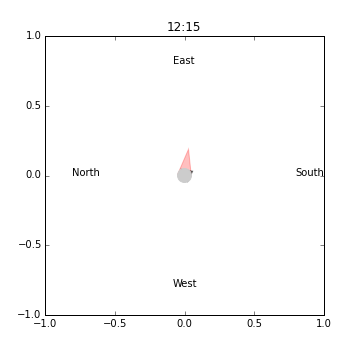
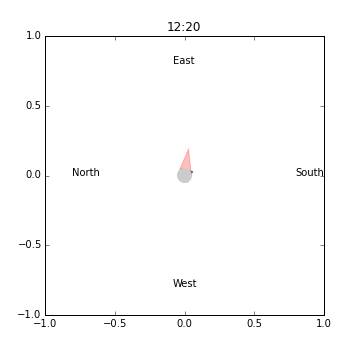
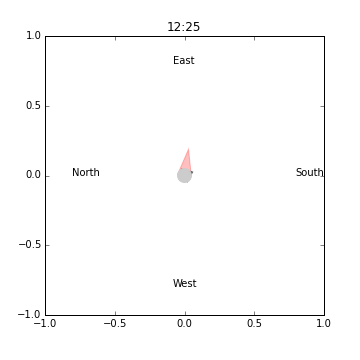
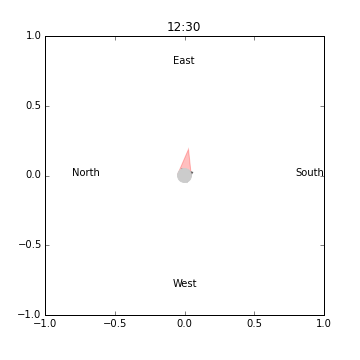
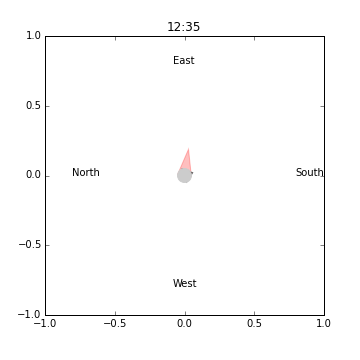
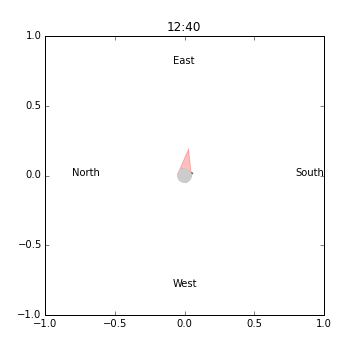
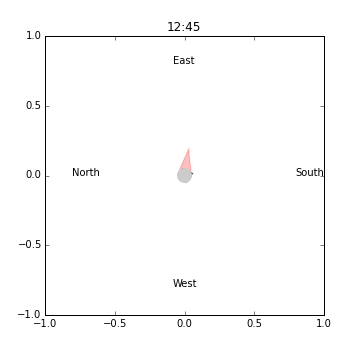
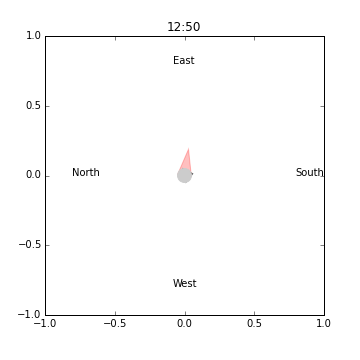
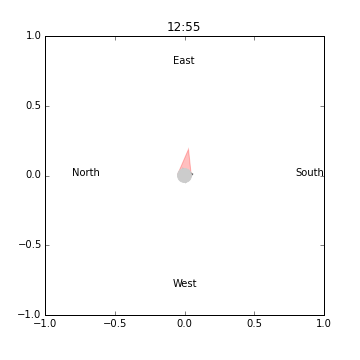
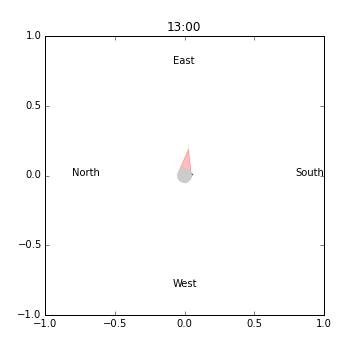
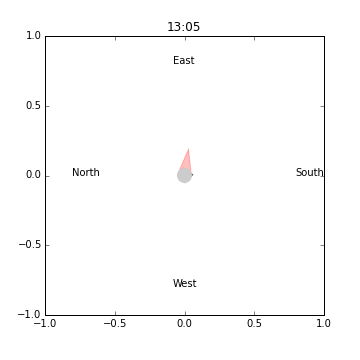
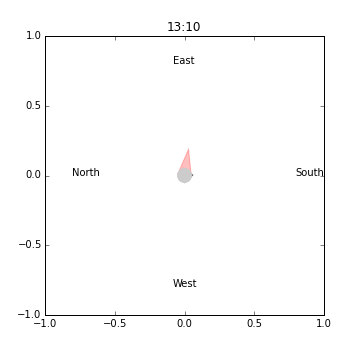
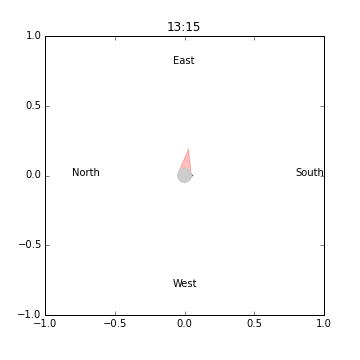
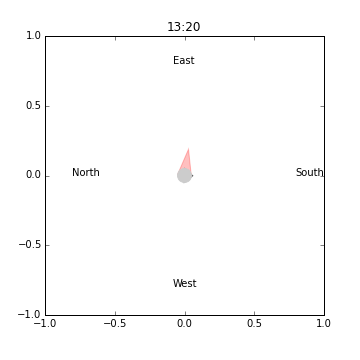
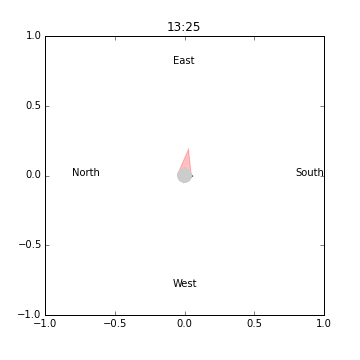
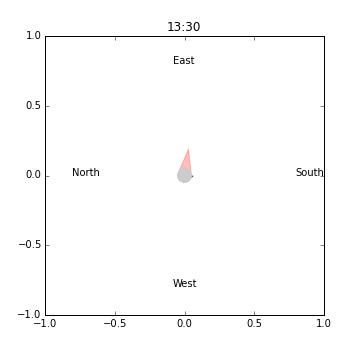
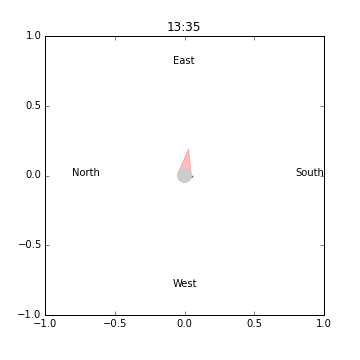
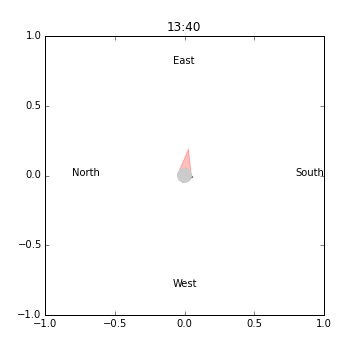
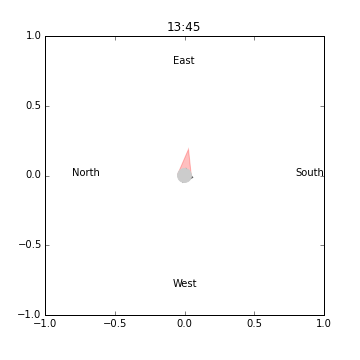
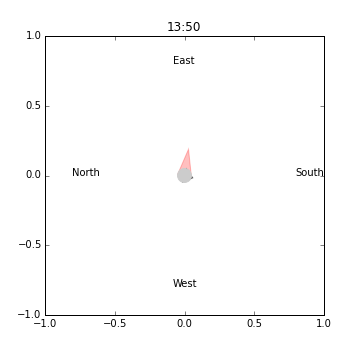
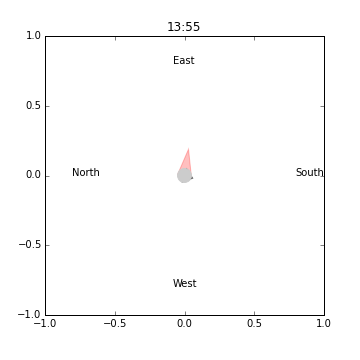
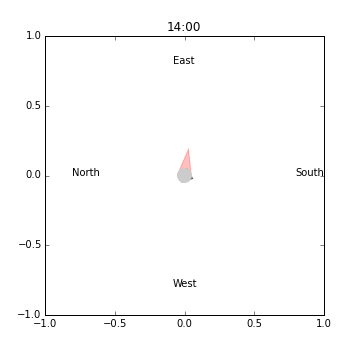
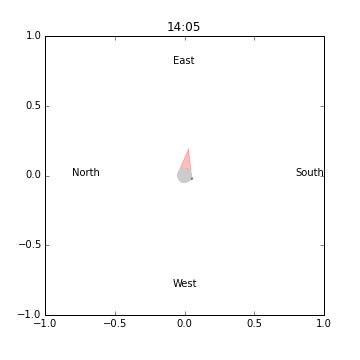
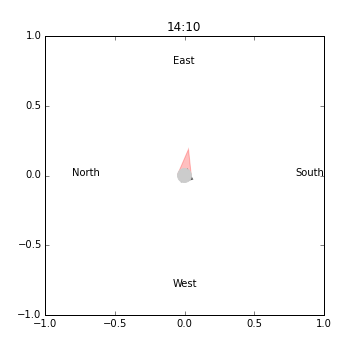
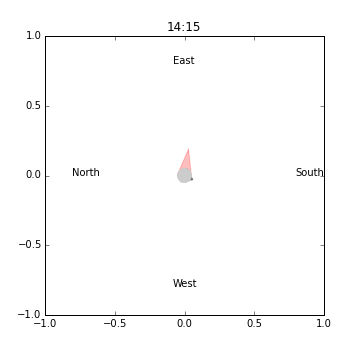
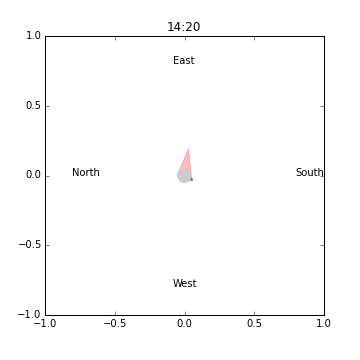
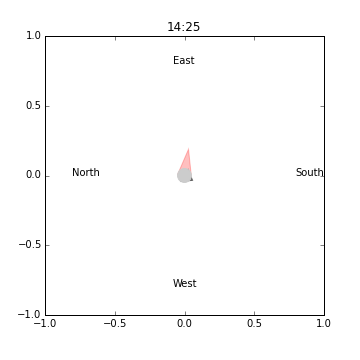
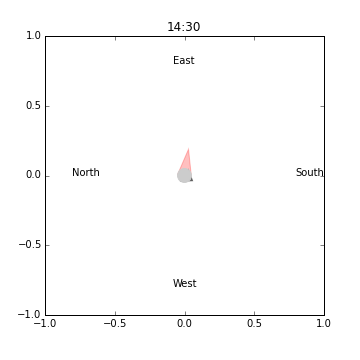
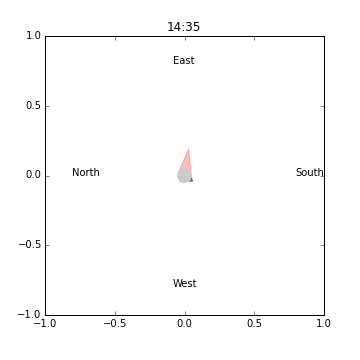
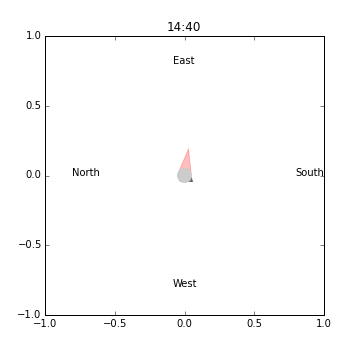
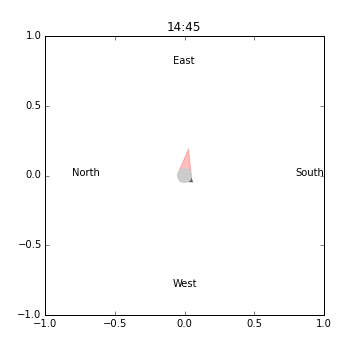
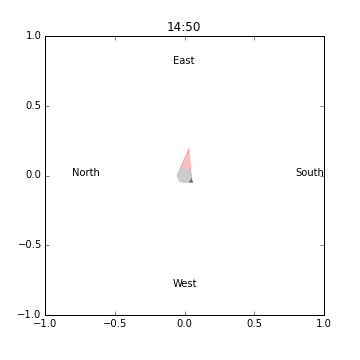
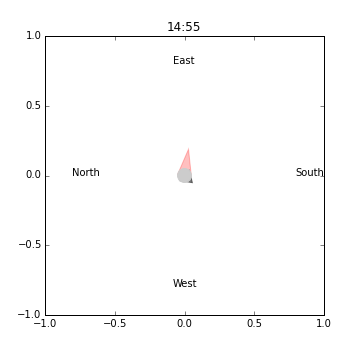
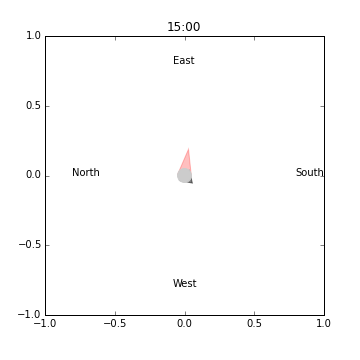
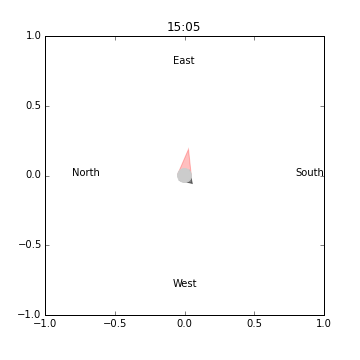
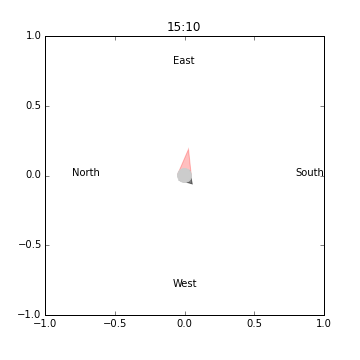
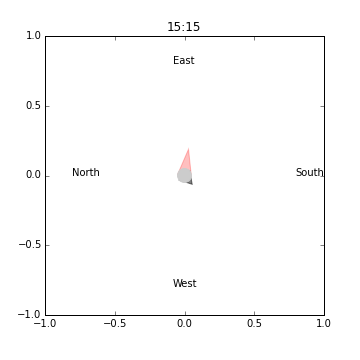
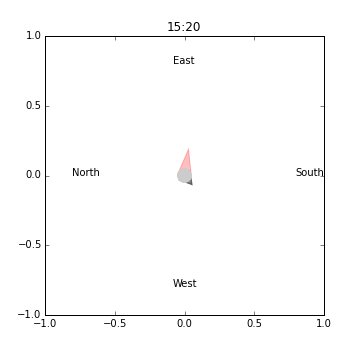
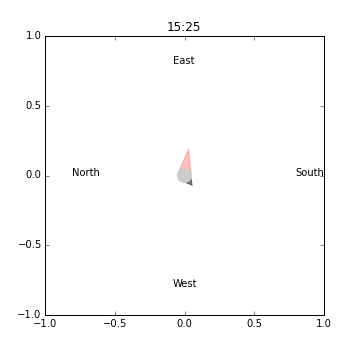
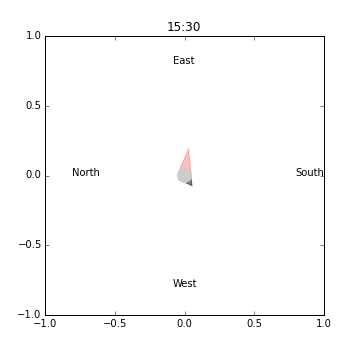
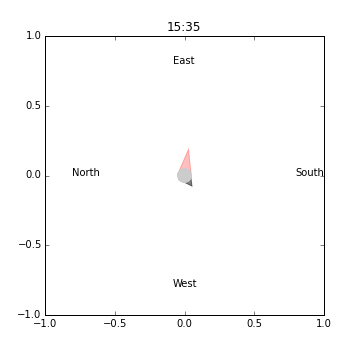
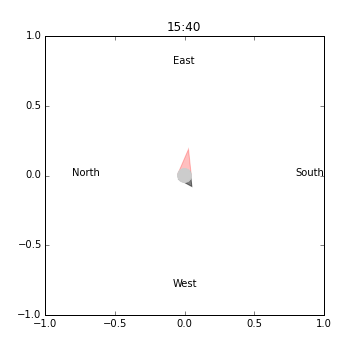
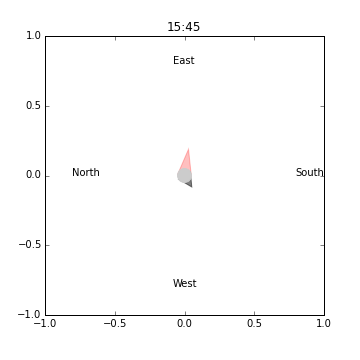
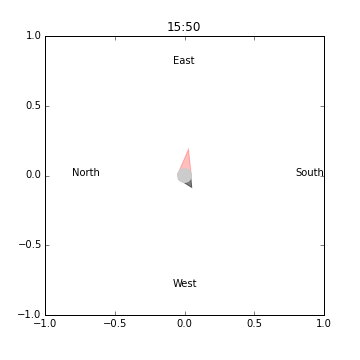
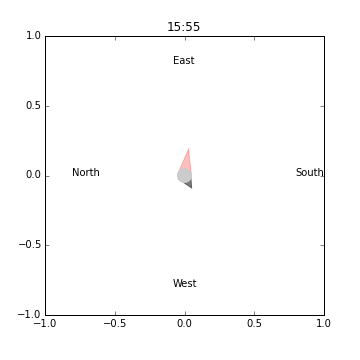
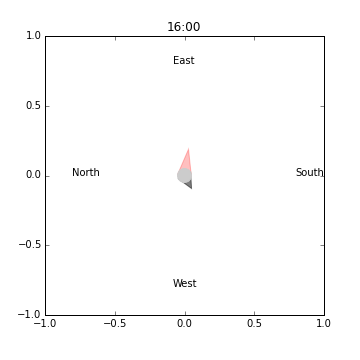
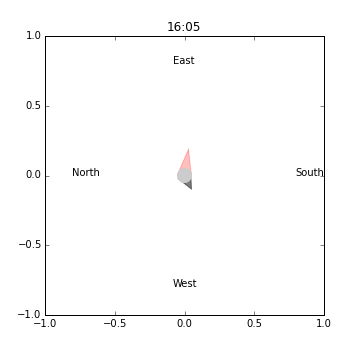
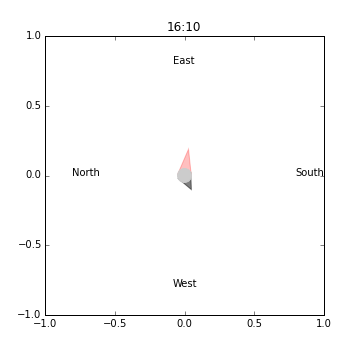
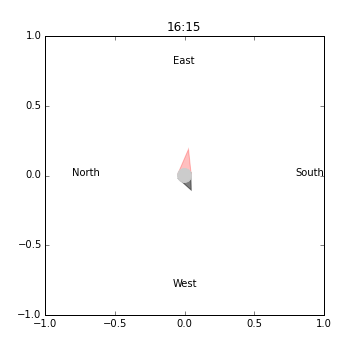
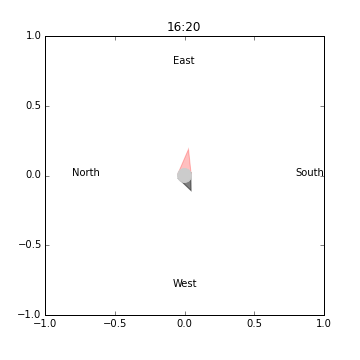
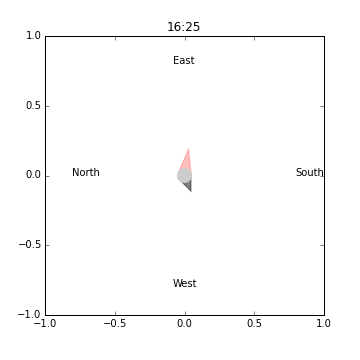
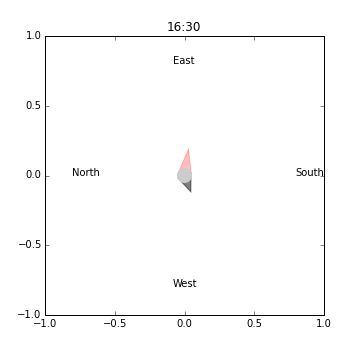
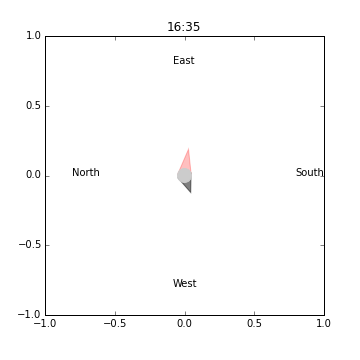
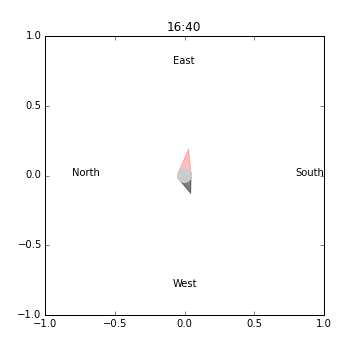
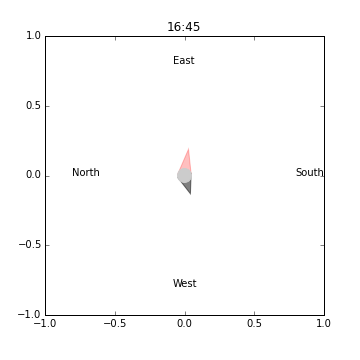
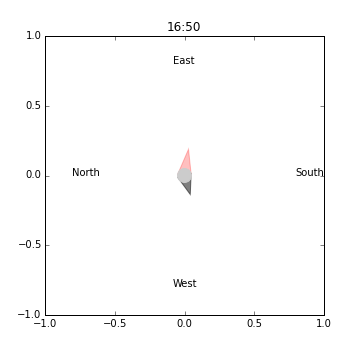
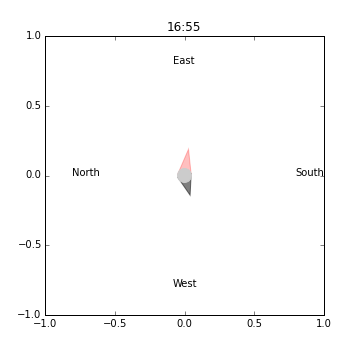
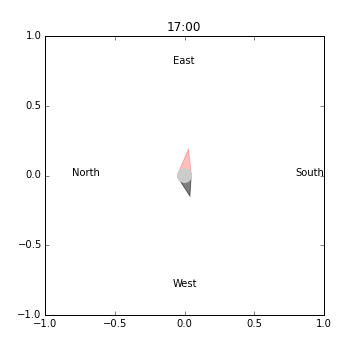
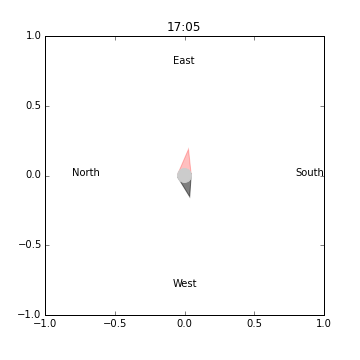
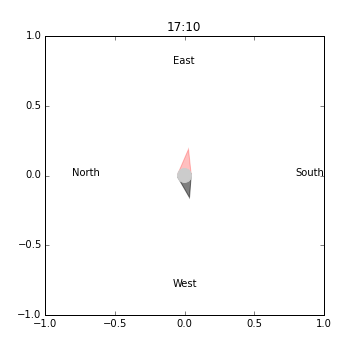
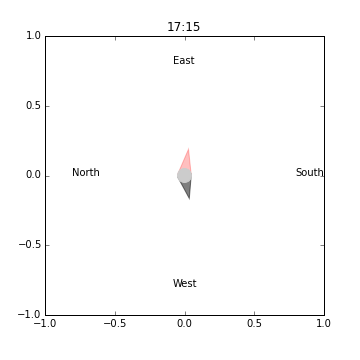
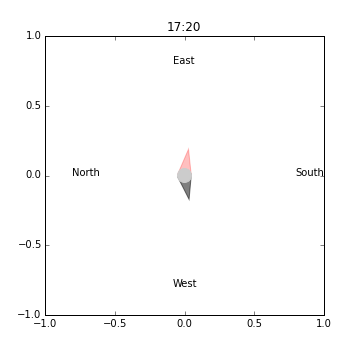
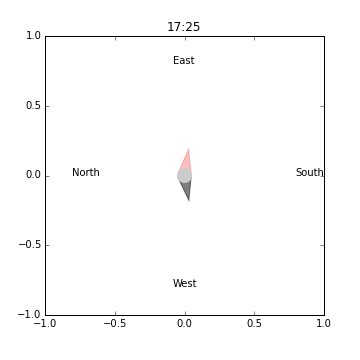
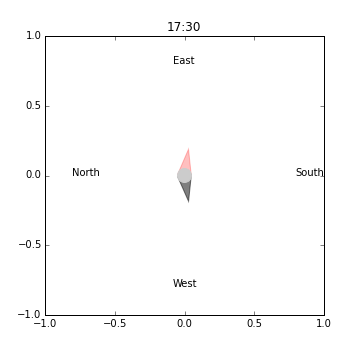
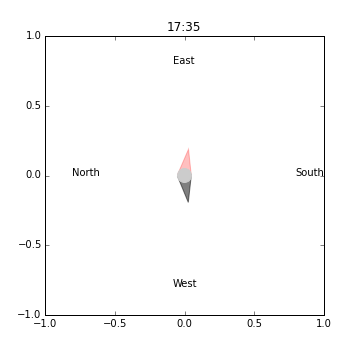
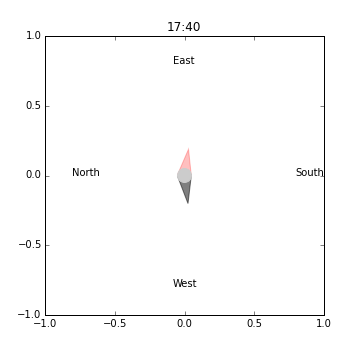
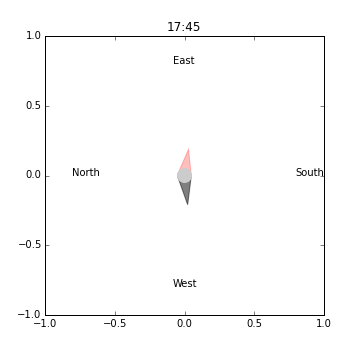
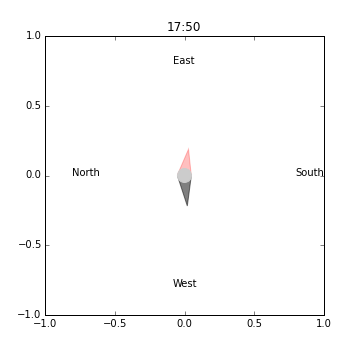
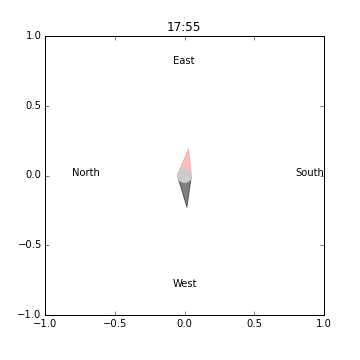
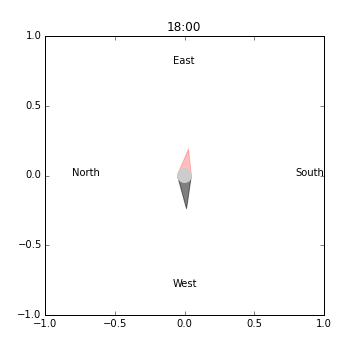
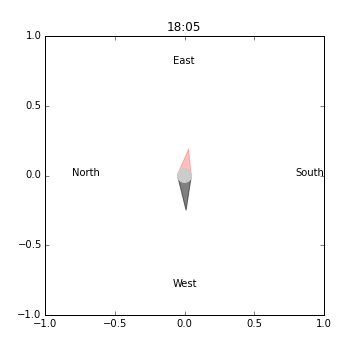
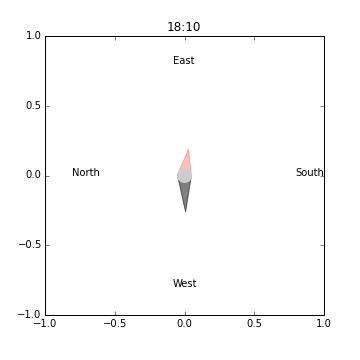
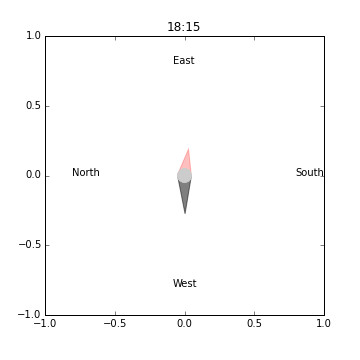
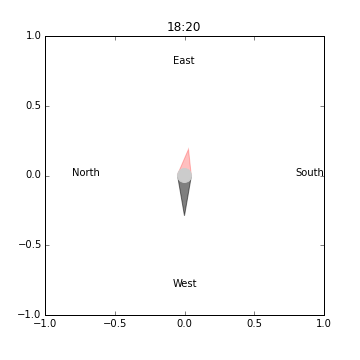
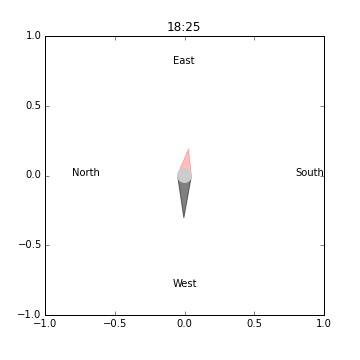
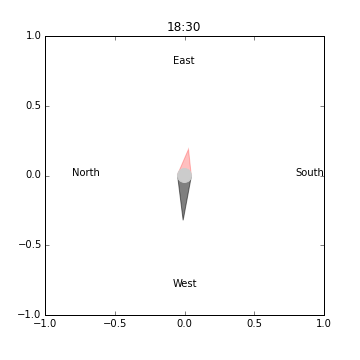
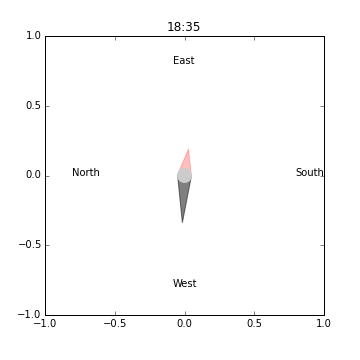
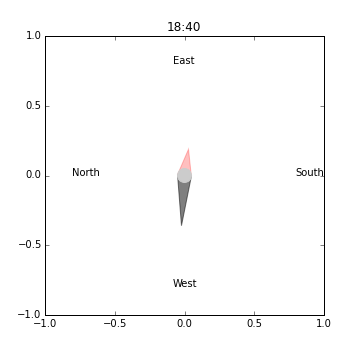
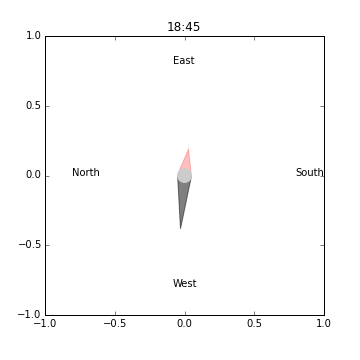
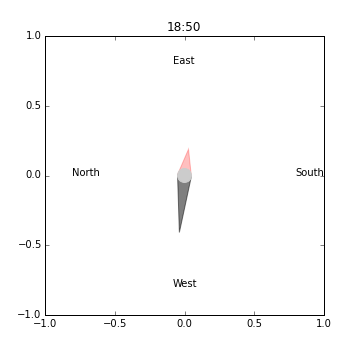
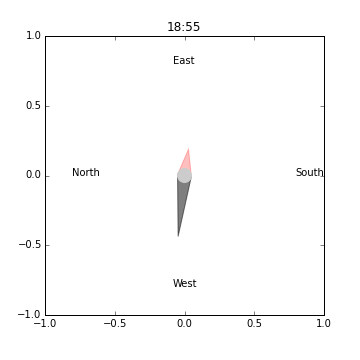
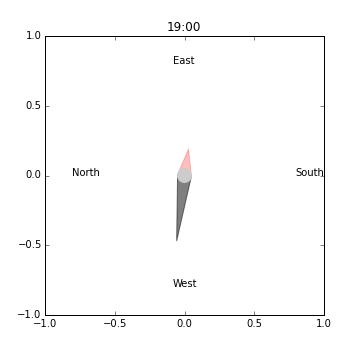
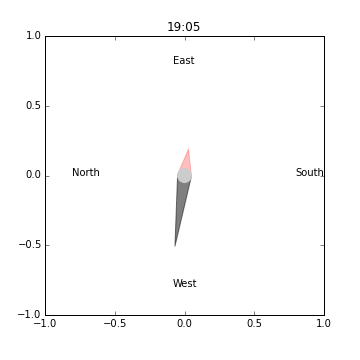
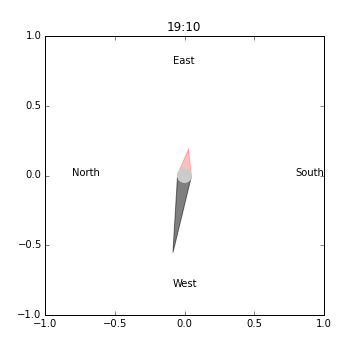
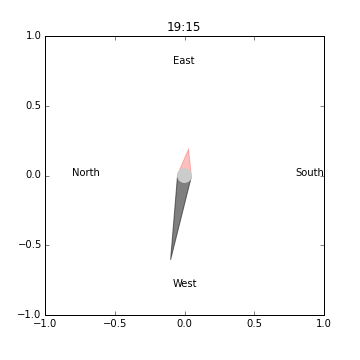
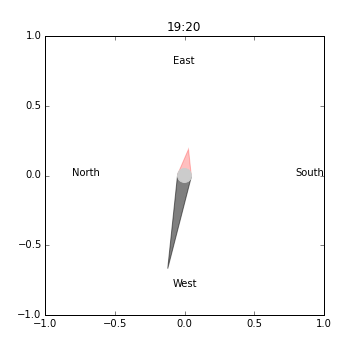
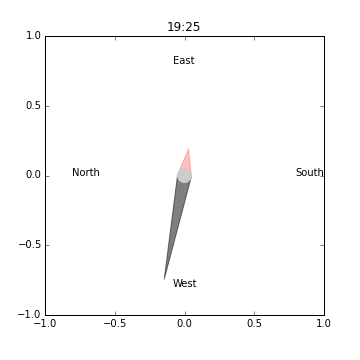
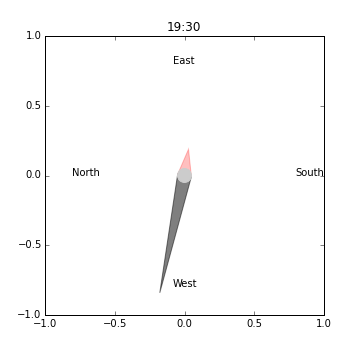
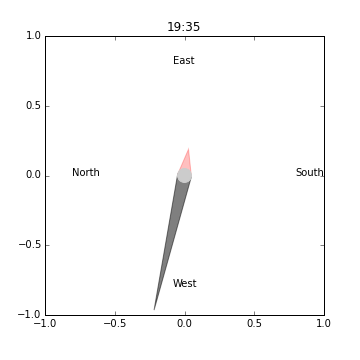
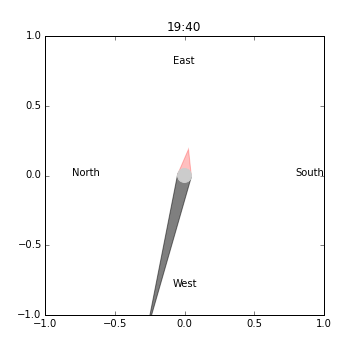
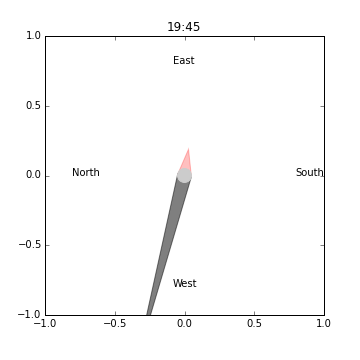
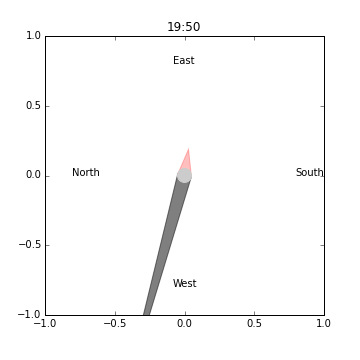
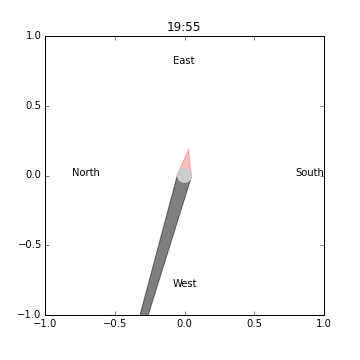
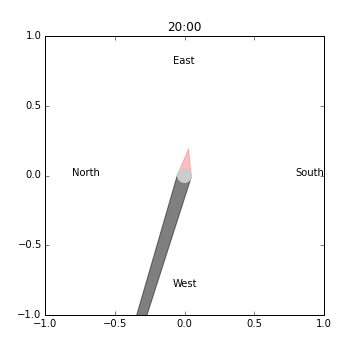
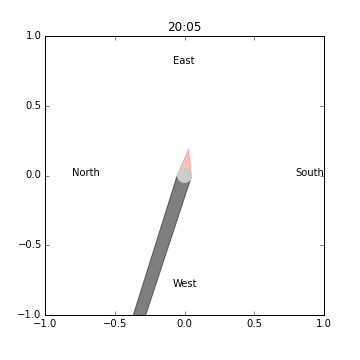
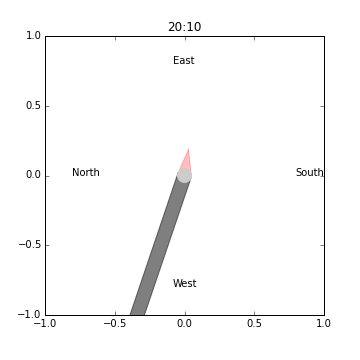
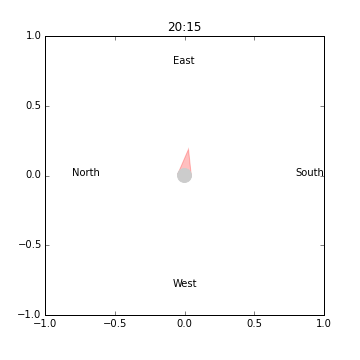
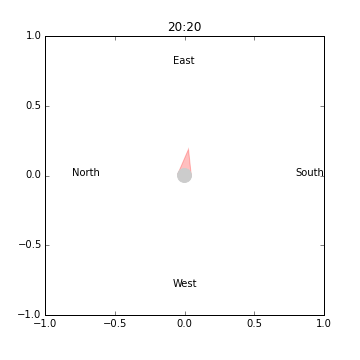
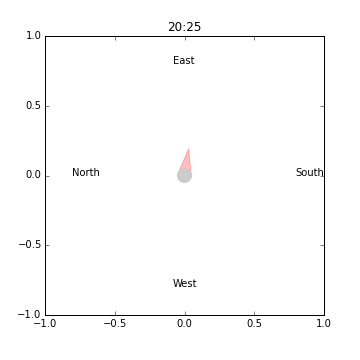
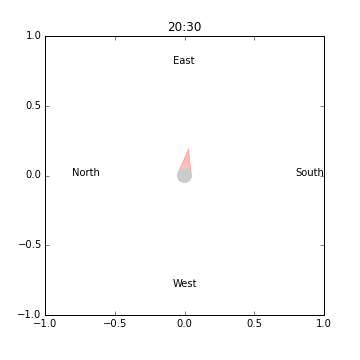
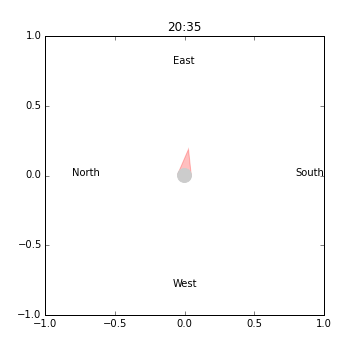
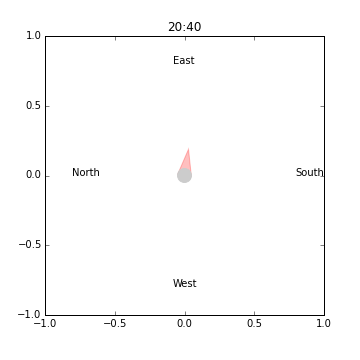
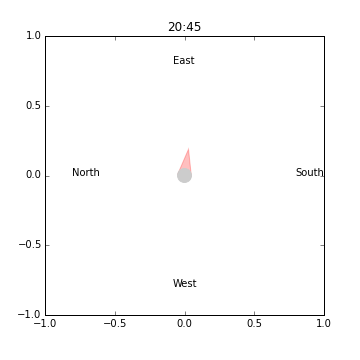
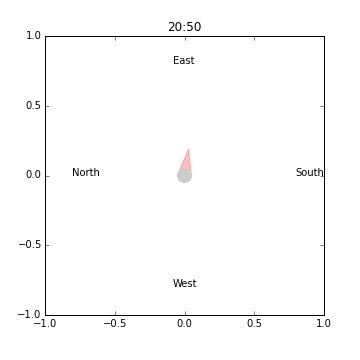
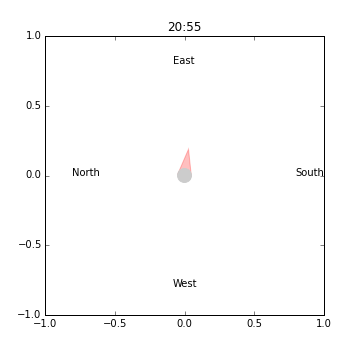
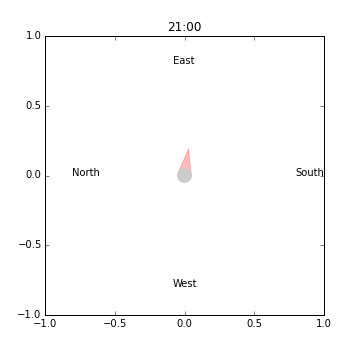
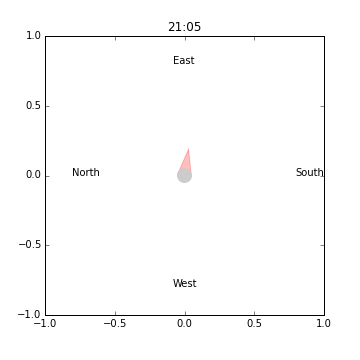
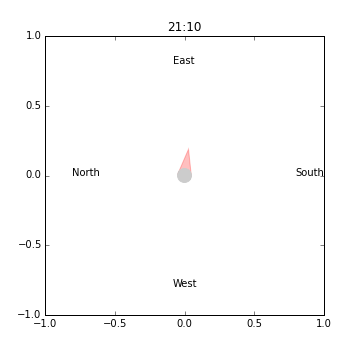
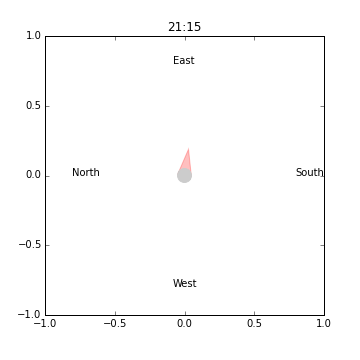
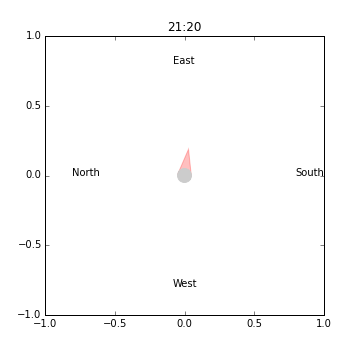
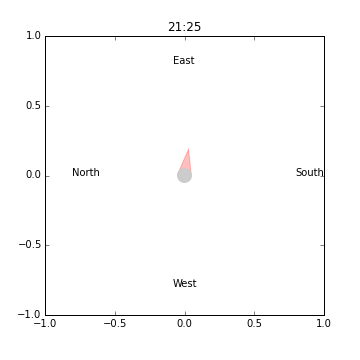
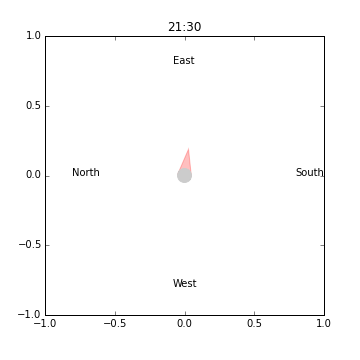
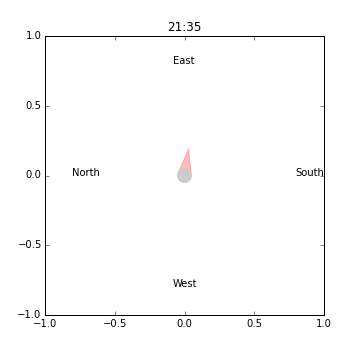
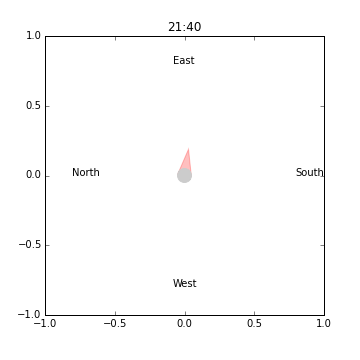
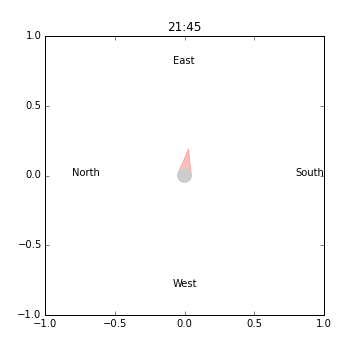
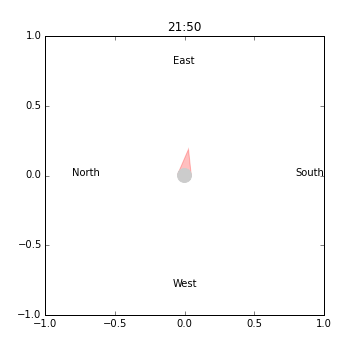
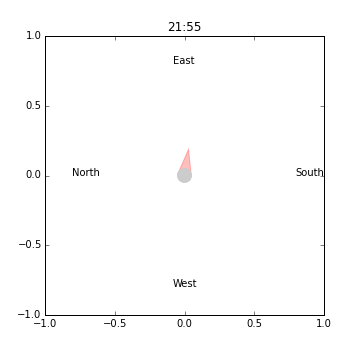
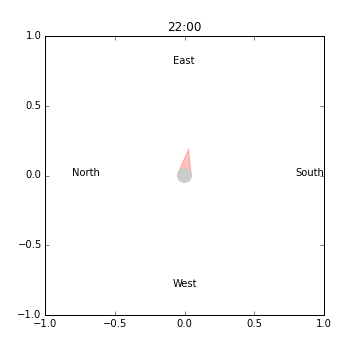
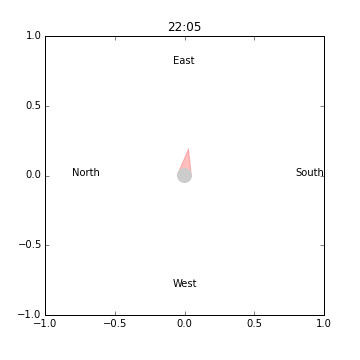
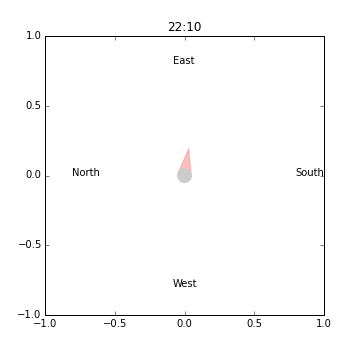
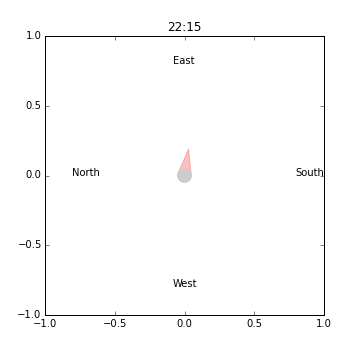
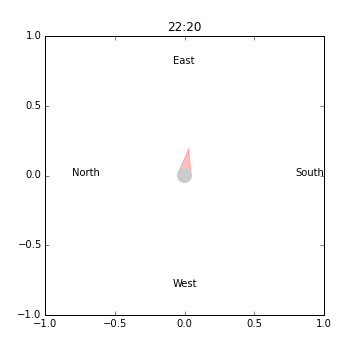
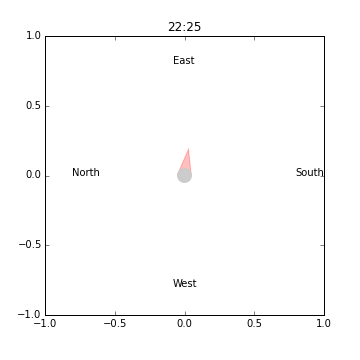
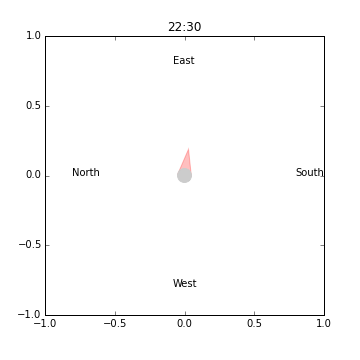
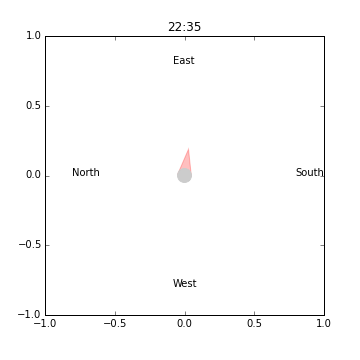
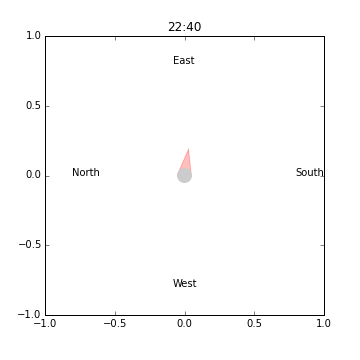
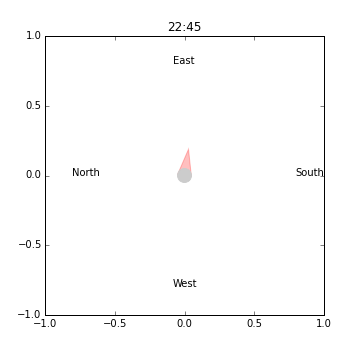
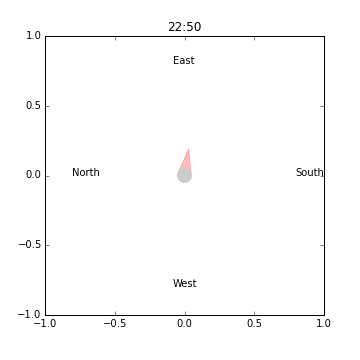
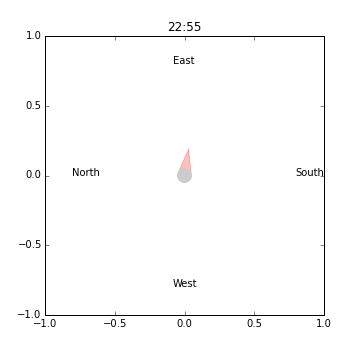
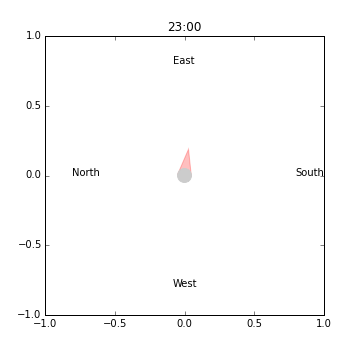

In [39]:
# create an animation of a simple shadow
fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
ax.axis('equal')
ax.axis([-1, 1,-1, 1])
ax.annotate('East', xy=(0., 0.8), ha="center")
ax.annotate('West', xy=(0., -0.8), ha="center")
ax.annotate('South', xy=(0.8, 0.))
ax.annotate('North', xy=(-0.8, 0.))
time = ax.annotate('', xy=(0.8, 0.8))

# Our generic fake object (cone)
object_height = 0.1
object_radius = 0.05

# Teach time
teach_hour = 9 # in hour
teach_date = table.index[0].replace(hour=teach_hour)
teach_id = table.index.searchsorted(teach_date)
sun_altitude = table.irow(teach_id)['sun_altitude']
sun_azimuth = table.irow(teach_id)['sun_azimuth']
coords = compute_shadow(object_height, sun_altitude, sun_azimuth)
shadow_teach = Polygon(coords, closed=True, color='r', alpha=0.25)
ax.add_artist(shadow_teach)


shadow = Polygon([[0, 0]], closed=True, color='k', alpha=0.5)
ax.add_artist(shadow)
circle = plt.Circle((0,0), object_radius, color='0.8')
ax.add_artist(circle)




def animate(i):
    sun_altitude = table.irow(i)['sun_altitude']
    sun_azimuth = table.irow(i)['sun_azimuth']

    ax.set_title("%i:%02i" % (table.index[i].hour, table.index[i].minute))
     
    shadow.xy = compute_shadow(object_height, sun_altitude, sun_azimuth)
    
    return ax, time

nb_data = len(table.index)
animation.FuncAnimation(fig, animate,
                        frames=nb_data, interval=50, blit=True)

In [236]:
def shadow_diff(teach_shadow_tip, repeat_shadow_tip):
    '''
    This is based on Hausdorff distance with an exponential map. 
    See https://en.wikipedia.org/wiki/Hausdorff_distance
    '''
    return np.exp(-((norm(teach_shadow_tip - repeat_shadow_tip))**1.)/0.05)
    

In [352]:
def compute_soft_ratio(sun_altitude, effective_horizon):
    '''
    Smooth transition between soft and hard shadows using sigmoids.
    '''
    return 1/(1 + np.exp(((sun_altitude - effective_horizon))/.08))

In [359]:
nb_data = len(table.index)

# Teach time
teach_hour = 7 # in hour
teach_min = 35 # in minutes
teach_date = table.index[0].replace(hour=teach_hour).replace(minute=teach_min)
teach_id = table.index.searchsorted(teach_date)

sun_altitude = table.irow(teach_id)['sun_altitude']
sun_azimuth = table.irow(teach_id)['sun_azimuth']
coords_teach = compute_shadow(object_height, sun_altitude, sun_azimuth)
weight_soft_teach = compute_soft_ratio(sun_altitude, effective_horizon)
shadow_teach_diff_soft = shadow_diff(coords_teach[0], (0,0))

# Assign empty array
ratio_features = np.empty(nb_data)
shadow_similarity_hard = np.empty(nb_data)
shadow_similarity_soft = np.empty(nb_data)
shadow_soft_weight = np.empty(nb_data)
auto_exposure_limit = np.empty(nb_data)

for repeat_id in np.arange(nb_data):
    
    sun_altitude = table.irow(repeat_id)['sun_altitude']
    sun_azimuth = table.irow(repeat_id)['sun_azimuth']
    
    coords_repeat = compute_shadow(object_height, sun_altitude, sun_azimuth)

    shadow_diff_hard = shadow_diff(coords_teach[0], coords_repeat[0])
    shadow_diff_soft = shadow_diff((0,0), coords_repeat[0])
    
    w = compute_soft_ratio(sun_altitude, effective_horizon)
    ae_lim = 1/(1 + np.exp(-((sun_altitude - sensor_limit))/.02))
    
    #(1 - weight_soft_teach*(w*shadow_teach_diff_soft + (1 - w)*shadow_diff_hard) +
    # weight_soft_teach*(w + shadow_diff_soft*(1-w))
    ratio_features[repeat_id] = ((1 - weight_soft_teach)*(w*shadow_teach_diff_soft + (1 - w)*shadow_diff_hard)
                                 +
                                 weight_soft_teach*(w + shadow_diff_soft*(1-w))
                                )*ae_lim
    
    # for debugging purpose
    shadow_similarity_hard[repeat_id] = shadow_diff_hard
    shadow_similarity_soft[repeat_id] = shadow_diff_soft
    shadow_soft_weight[repeat_id] = w
    auto_exposure_limit[repeat_id] = ae_lim
    

(0, 1)

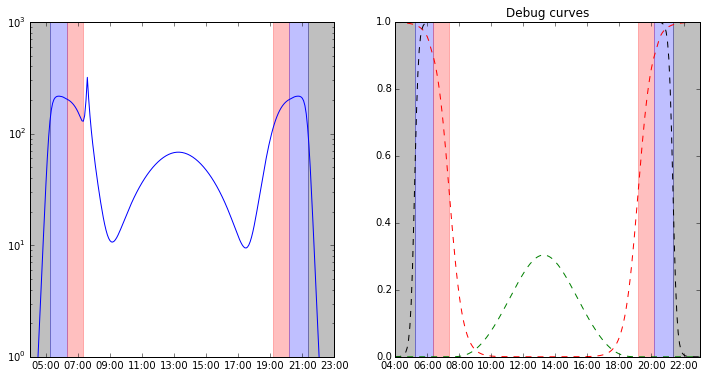

In [360]:
early = table.sun_azimuth < -np.pi
late = table.sun_azimuth > -np.pi

time_shadow_rise = (table.sun_altitude[early] - horizon_shadows).abs().argmin()
time_shadow_set = (table.sun_altitude[late] - horizon_shadows).abs().argmin()
time_sun_rise = table.sun_altitude[early].abs().argmin()
time_sun_set = table.sun_altitude[late].abs().argmin()
time_dawn = (table.sun_altitude[early] - dawn_nautical).abs().argmin()
time_dusk = (table.sun_altitude[late] - dawn_nautical).abs().argmin()

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax1.axvspan(table.index[0], time_dawn, color='k', alpha=0.25)
ax1.axvspan(time_dawn, time_sun_rise, color='b', alpha=0.25)
ax1.axvspan(time_sun_rise, time_shadow_rise, color='r', alpha=0.25)
ax1.axvspan(time_sun_set, time_shadow_set, color='r', alpha=0.25)
ax1.axvspan(time_dusk, time_sun_set, color='b', alpha=0.25)
ax1.axvspan(table.index[-1], time_dusk, color='k', alpha=0.25)

ax1.plot_date(table.index, ratio_features*600, '-')

ax1.xaxis.set_major_formatter(format_HM)
ax1.set_yscale('log')
ax1.set_ylim((1,1000))

# Second plot for the weights
ax2 = fig.add_subplot(122)
ax2.axvspan(table.index[0], time_dawn, color='k', alpha=0.25)
ax2.axvspan(time_dawn, time_sun_rise, color='b', alpha=0.25)
ax2.axvspan(time_sun_rise, time_shadow_rise, color='r', alpha=0.25)
ax2.axvspan(time_sun_set, time_shadow_set, color='r', alpha=0.25)
ax2.axvspan(time_dusk, time_sun_set, color='b', alpha=0.25)
ax2.axvspan(table.index[-1], time_dusk, color='k', alpha=0.25)

ax2.plot_date(table.index, shadow_soft_weight, 'r--')
ax2.plot_date(table.index, auto_exposure_limit, 'k--')
ax2.plot_date(table.index, shadow_similarity_soft, 'g--')

ax2.xaxis.set_major_formatter(format_HM)
ax2.set_title('Debug curves')
ax2.set_ylim((0,1))

## Simple model for global sun radiation

__Note: not sure the we need the following yet__

This [article/report](http://www.nrel.gov/rredc/pdfs/761.pdf) from the Solar Energy Research Institute (Colorado) seems promising.
The conclusion of that report states that the model of LACIS AND HANSEN (see Section 2.5 of that report) is the simplest and yields results within 8% of observed data. 

<!--
See that figure:
<img src="http://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/clim/2003/15200442-16.15/1520-0442%282003%29016%3C2646%3Atirbte%3E2.0.co%3B2/production/images/large/i1520-0442-16-15-2646-f02.jpeg" height="50" >
-->

The following equations are based on:
Hottel, H. C. (1976), "A Simple Model for Estimating the Transmittance of Direct Solar Radiation Through Clear Atmospheres," Solar Energy 18 (2), 129 [Link (hard to find)](http://journals2.scholarsportal.info.myaccess.library.utoronto.ca/pdf/0038092x/v18i0002/129_asmfetdsrtca.xml). Unfortunatly, this is only the direct radiance model.

$$
I_e = I_0 \left(a_0 + a_1 \exp{\frac{-k}{\cos{\theta_z}}} \right) 
$$

with $I_0$ being the extraterrestrial irradiance and  $\theta_z$ is the solar zenith angle, which can be computed from the sun elevation $\theta_e$:
$$
\theta_z = \frac{\pi}{2} - \theta_e
$$

The parameter $a_0$, $a_1$ and $k$ can be the following for clear sky:

In [12]:
A = 0 # location altitude
clear_a_0 = 0.4237 - 0.00821*(6-A)**2
clear_a_1 = 0.5055 + 0.00595*(6.5-A)**2
clear_k = 0.2711 + 0.01858*(2.5-A)**2

print('a_0 = %f' % clear_a_0)
print('a_1 = %f' % clear_a_1)
print('k = %f' % clear_k)

a_0 = 0.128140
a_1 = 0.756887
k = 0.387225


The parameters for haze (5 km of visibility):

In [13]:
haze_a_0 = 0.2538 - 0.0063*(6-A)**2
haze_a_1 = 0.7678 + 0.0010*(6.5-A)**2
haze_k = 0.249 + 0.081*(2.5-A)**2

print('a_0 = %f' % haze_a_0)
print('a_1 = %f' % haze_a_1)
print('k = %f' % haze_k)

a_0 = 0.027000
a_1 = 0.810050
k = 0.755250


In [14]:
def irradiance(a_0, a_1, k, altitude):
    return a_0 + a_1 * np.exp(-k*(1/np.arccos(np.pi/2. - altitude)))

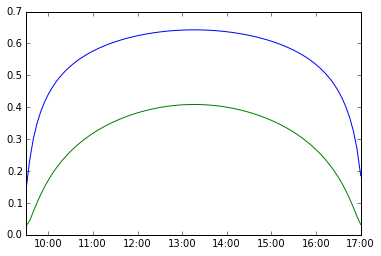

In [15]:
I_clear = irradiance(clear_a_0, clear_a_1, clear_k, table.sun_altitude)
I_haze = irradiance(haze_a_0, haze_a_1, haze_k, table.sun_altitude)
plt.plot(table.index, I_clear)
plt.plot(table.index, I_haze)
plt.gca().xaxis.set_major_formatter(format_HM)

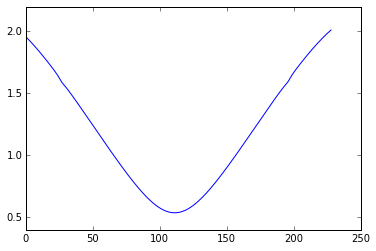

In [16]:
plt.plot((np.pi/2. - table.sun_altitude))

In [341]:
1 - weight_soft_teach

0.99999363180332024

In [298]:
shadow_teach_diff_soft

0.0